# Application of regression ANN, identification ANN and PiNN on the Lorenz system DHPMs


# Combined Bachelor Thesis (NS-320B), June 2022
## Mathematics & Physics and Astronomy
*'Applying Physics-informed Neural Networks to Chaotic Systems of Ordinary Differential Equations'*

**Author:** Martijn Sebastiaan Brouwer (6859488)

**Mathematics supervisors:** prof. dr. ir. C.W. Oosterlee

**Physics supervisor:** dr. J. de Graaf

**PhD supervisor:** B. Negyesi

# Regression ANN
### The fitting of the ANN on the RK4 data of the Lorenz system

Not connected to a GPU
ANN, iteration: 2500, loss: 36.64453887939453, time: 0:00:35.408825


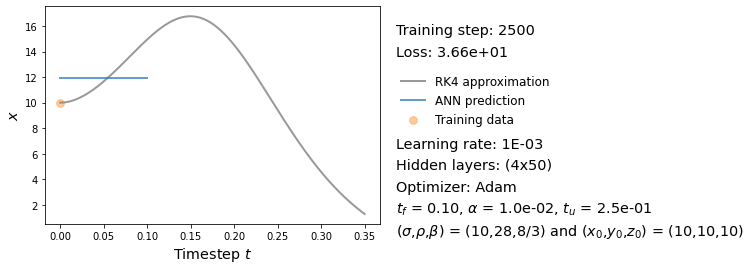

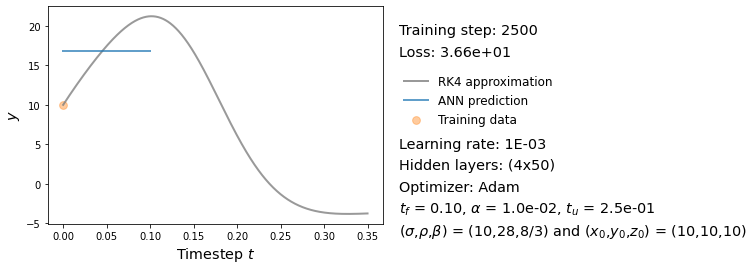

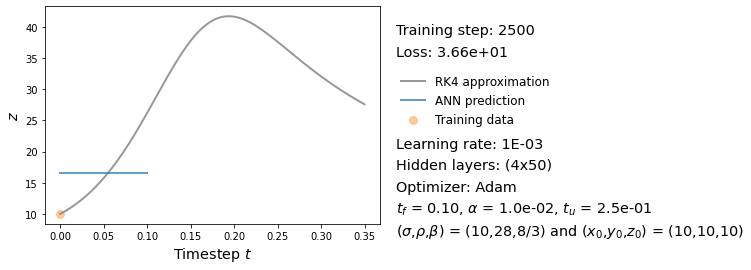

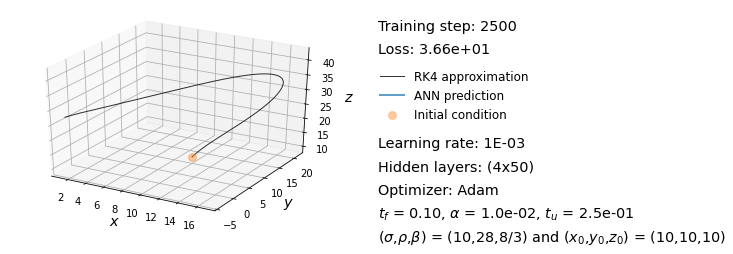

ANN, iteration: 5000, loss: 0.03162071853876114, time: 0:01:13.367611


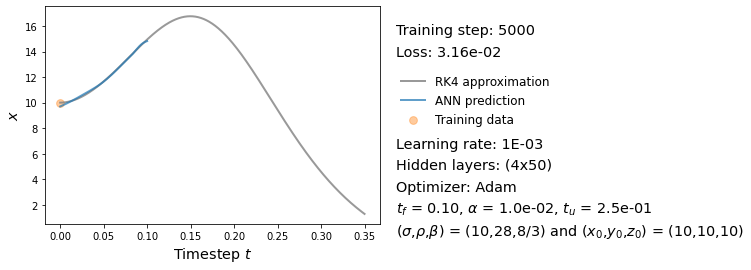

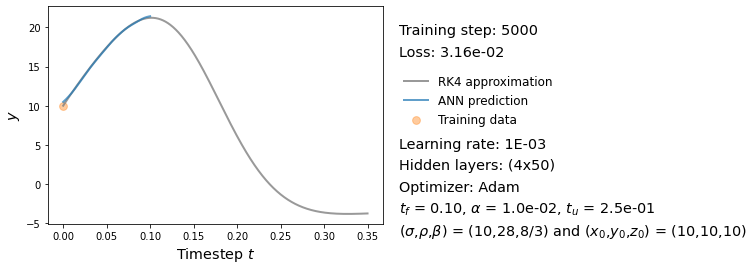

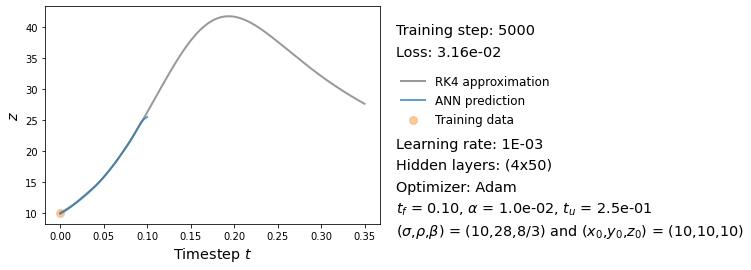

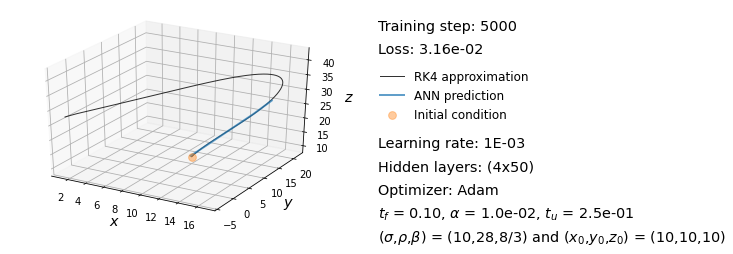

ANN, iteration: 7500, loss: 0.1449527144432068, time: 0:01:51.618442


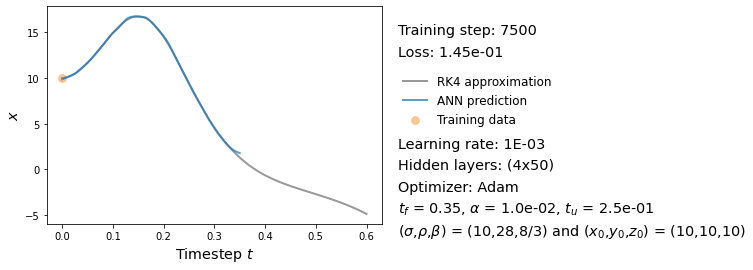

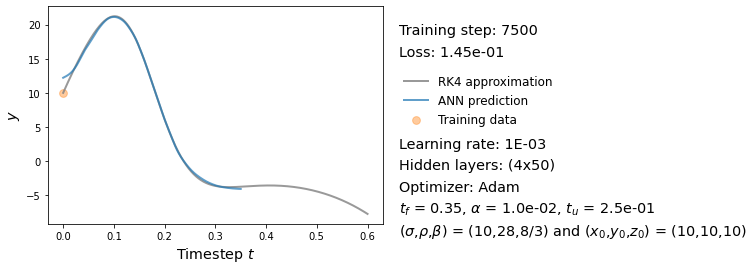

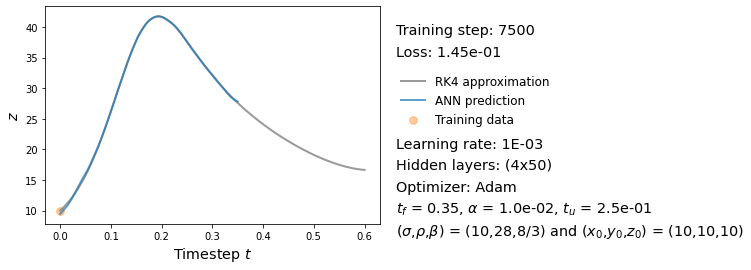

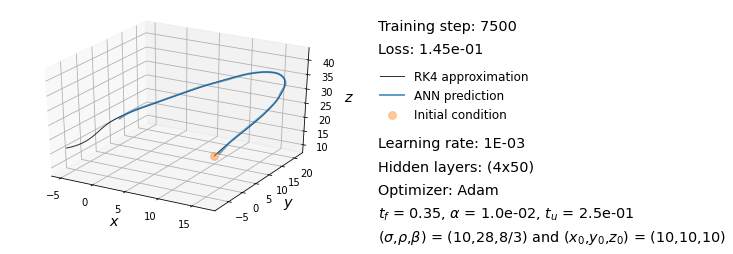

ANN, iteration: 10000, loss: 0.27789631485939026, time: 0:02:29.310361


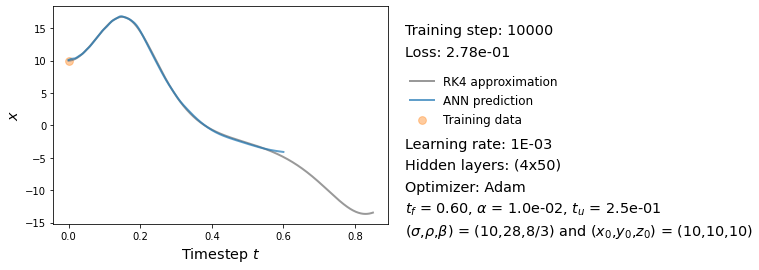

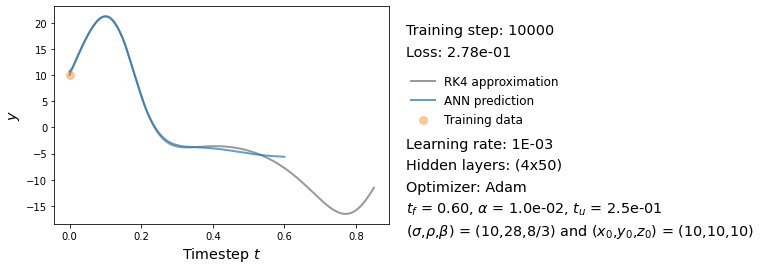

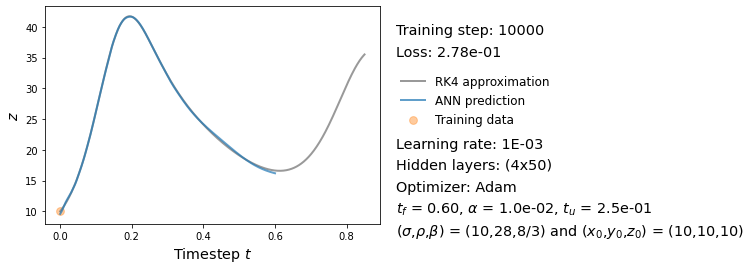

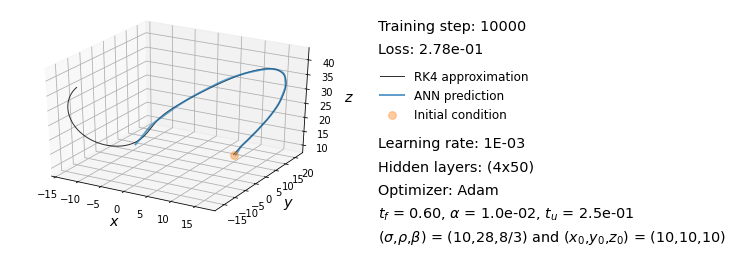

ANN, iteration: 12500, loss: 0.011231773532927036, time: 0:03:06.937278


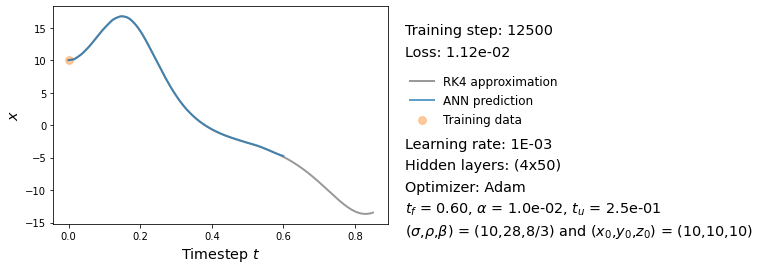

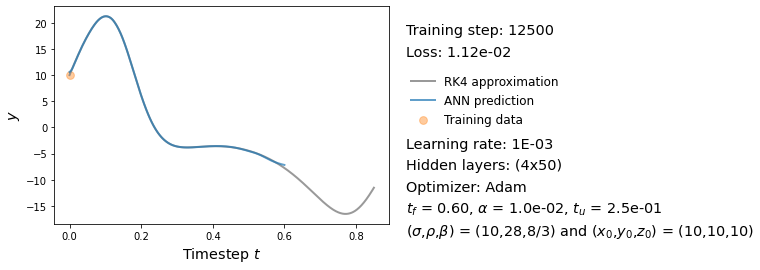

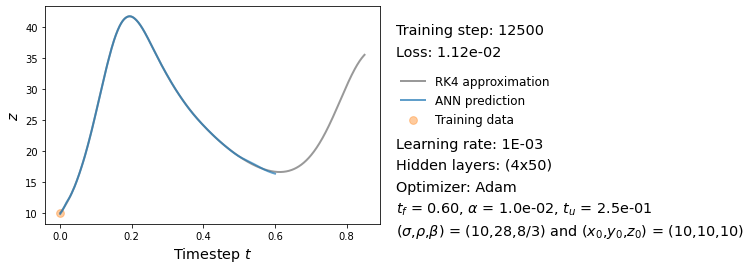

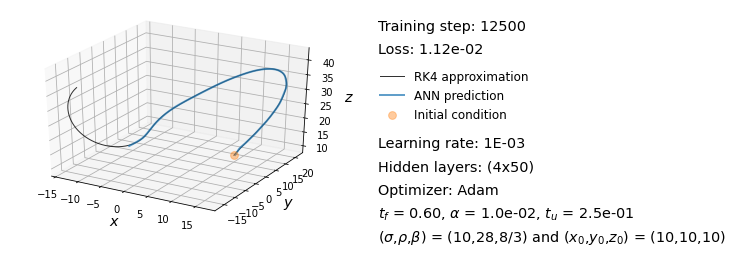

ANN, iteration: 15000, loss: 0.5161756277084351, time: 0:03:44.490360


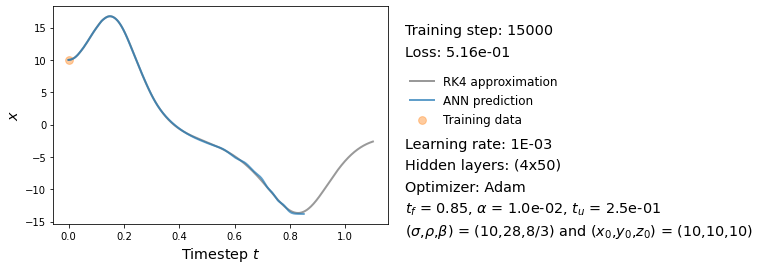

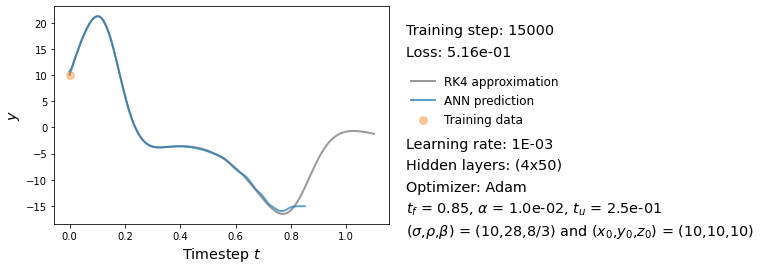

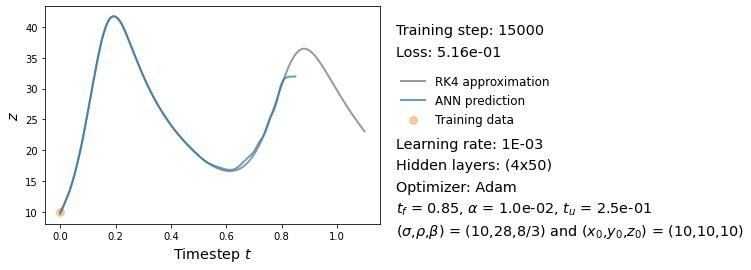

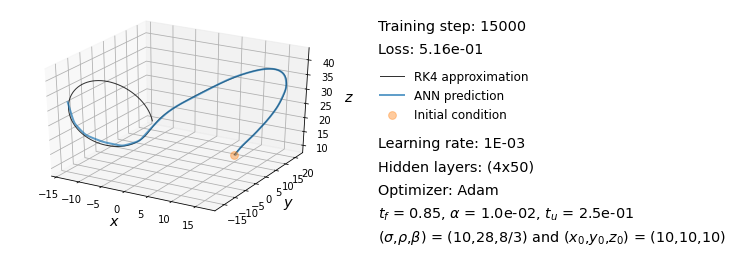

ANN, iteration: 17500, loss: 0.030614392831921577, time: 0:04:22.112581


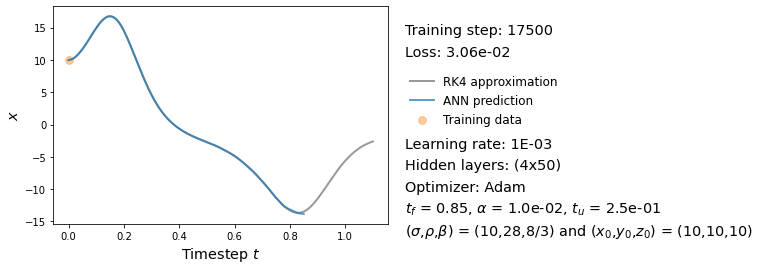

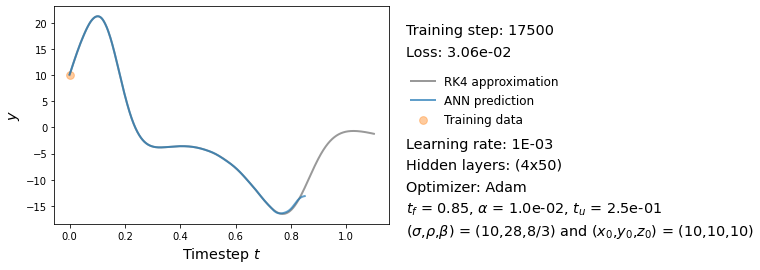

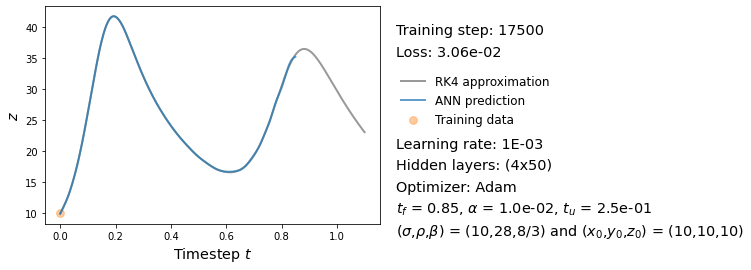

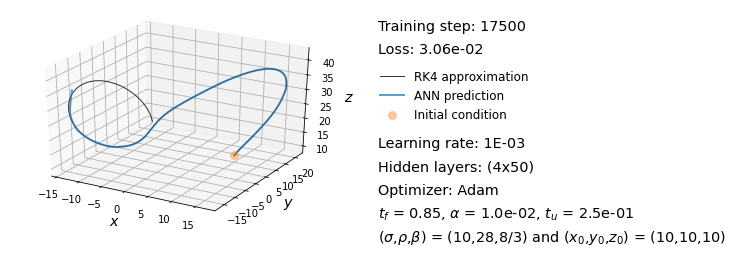

ANN, iteration: 20000, loss: 0.2799288332462311, time: 0:05:00.098430


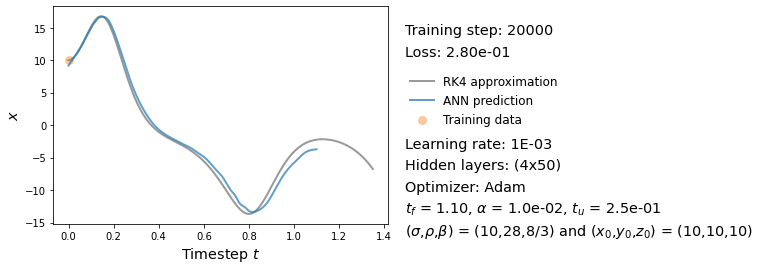

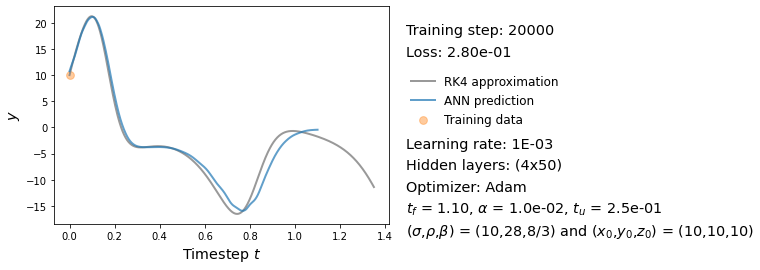

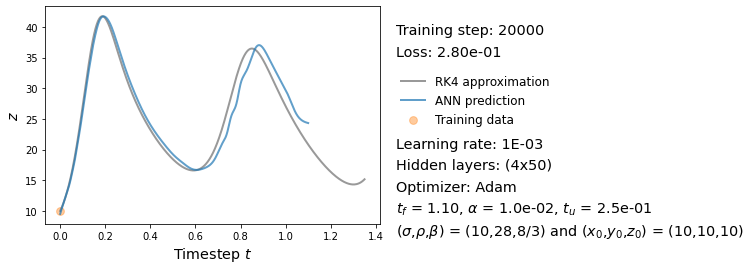

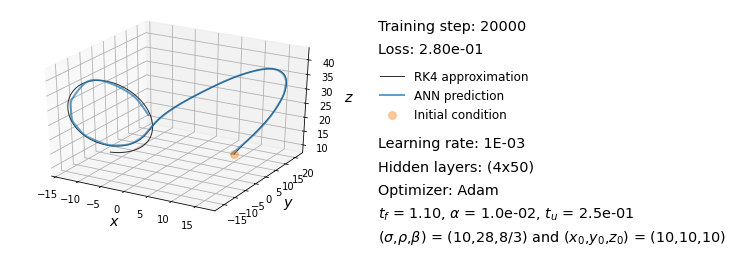

ANN, iteration: 22500, loss: 0.1368476003408432, time: 0:05:37.982684


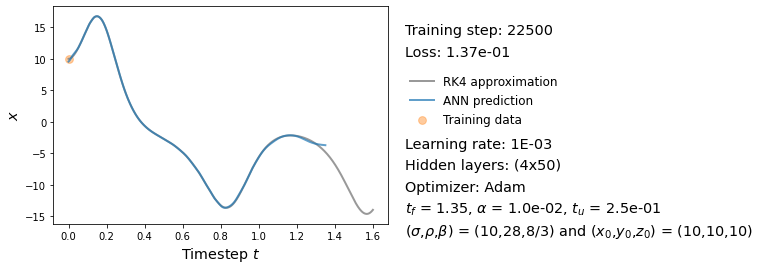

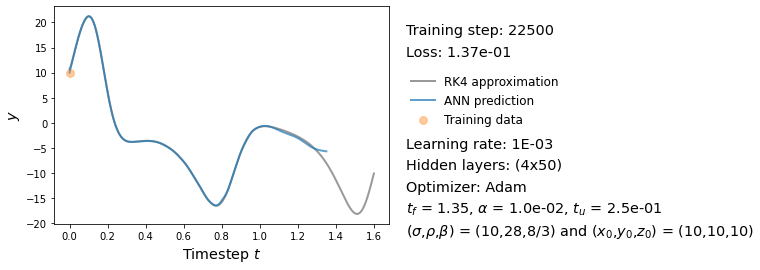

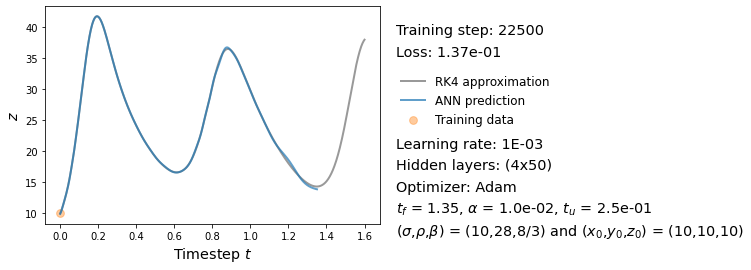

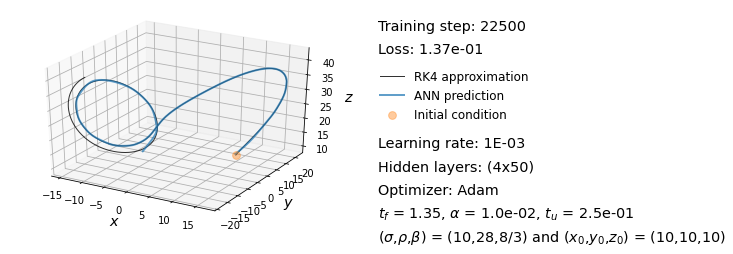

ANN, iteration: 25000, loss: 14.02054500579834, time: 0:06:16.336430


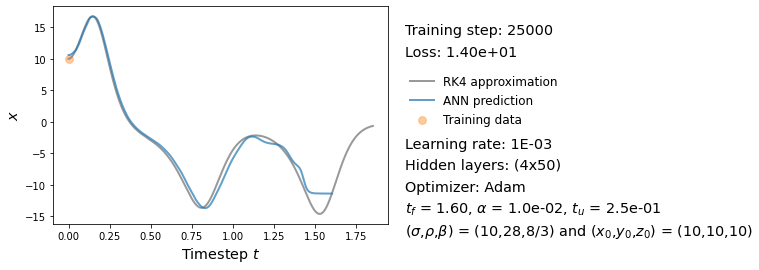

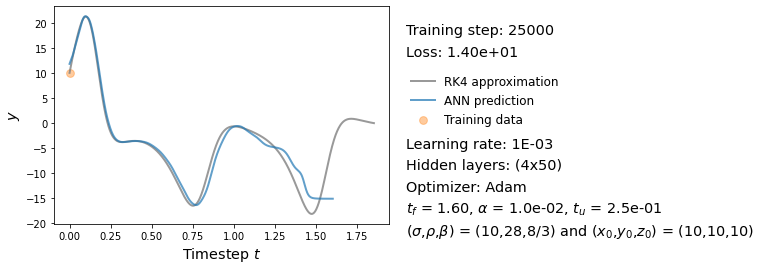

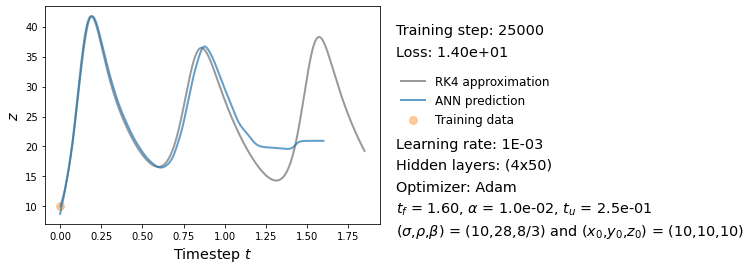

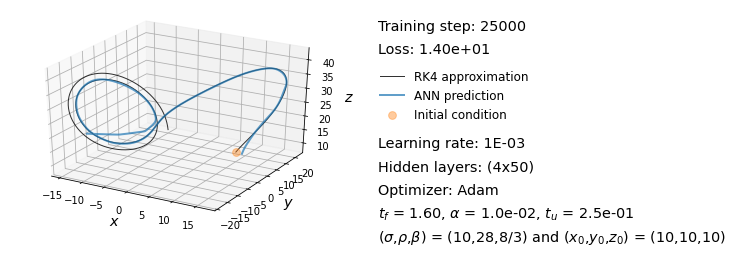

ANN, iteration: 27500, loss: 3.702336072921753, time: 0:06:54.377547


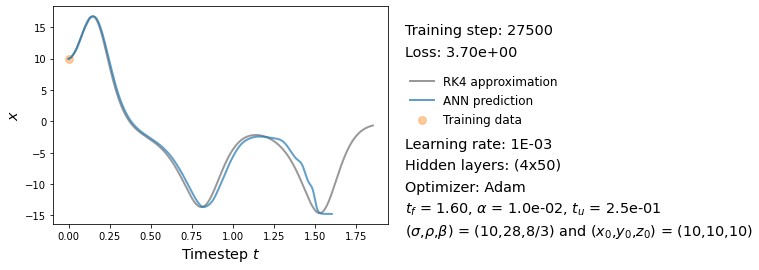

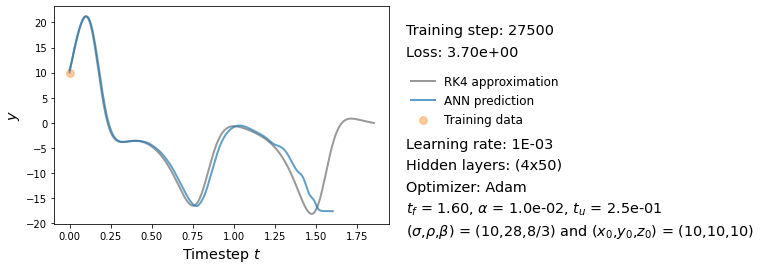

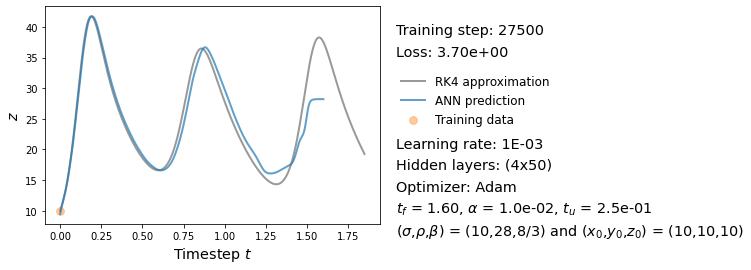

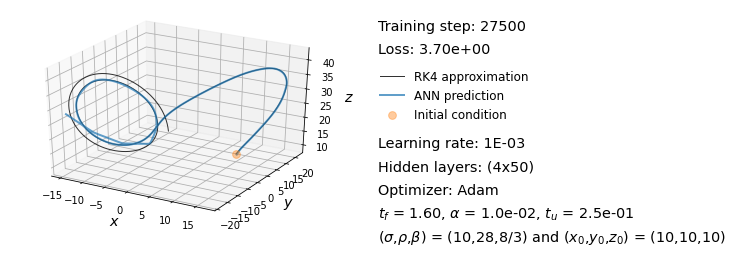

ANN, iteration: 30000, loss: 0.4244484603404999, time: 0:07:32.312212


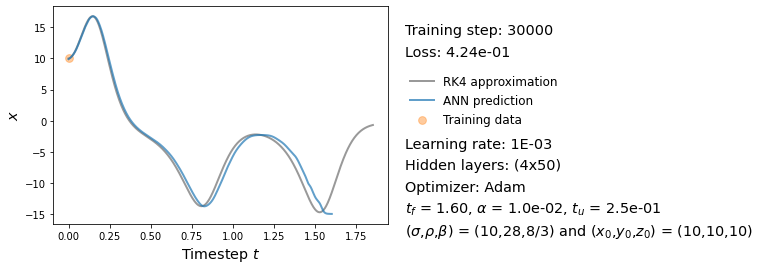

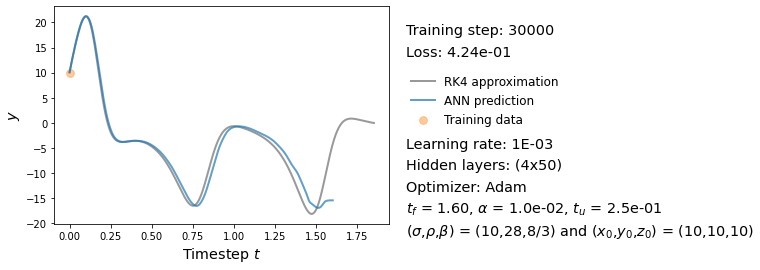

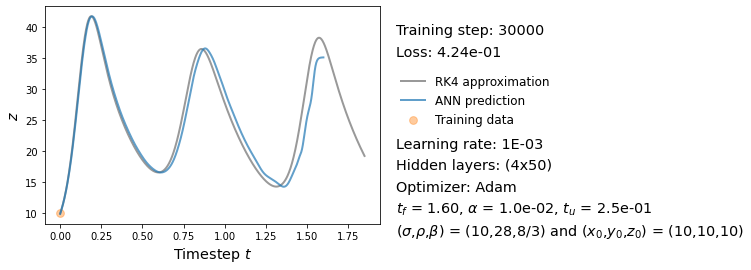

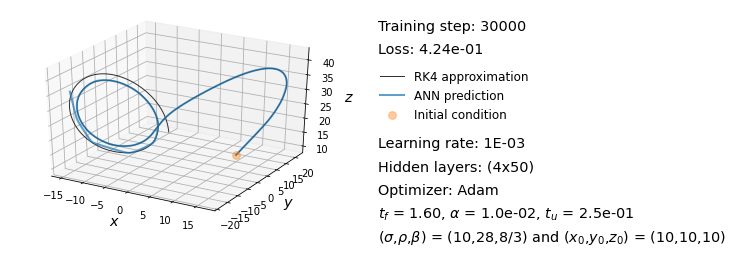

ANN, iteration: 32500, loss: 0.07705670595169067, time: 0:08:10.241898


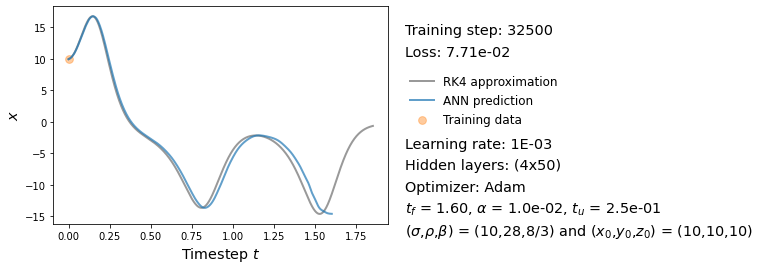

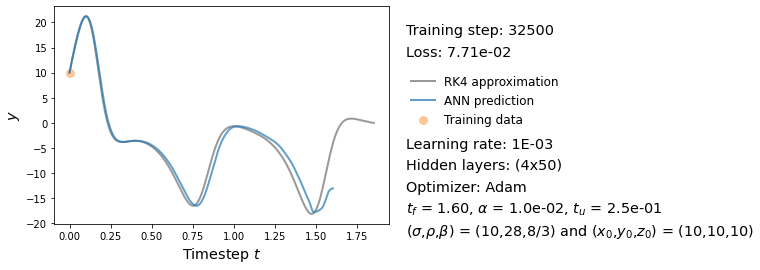

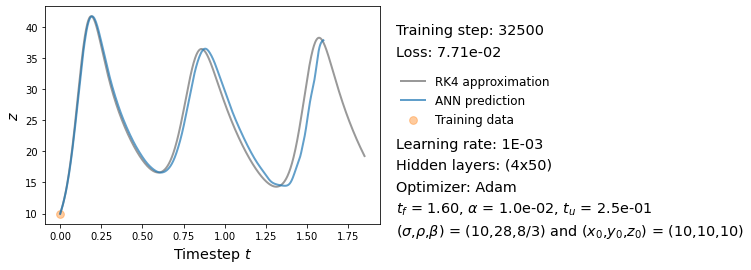

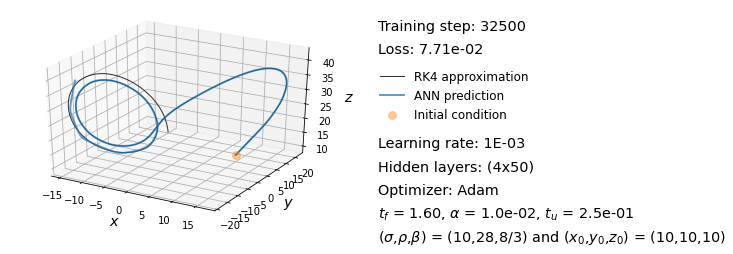

ANN, iteration: 35000, loss: 0.018076680600643158, time: 0:08:48.498991


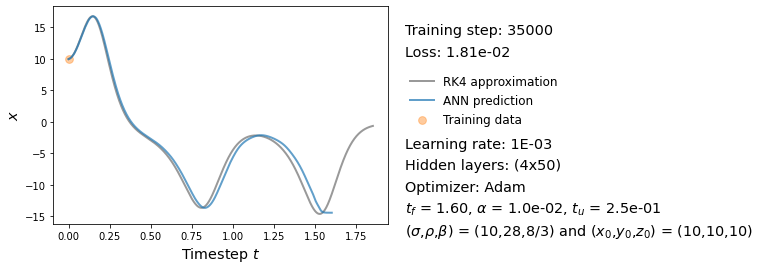

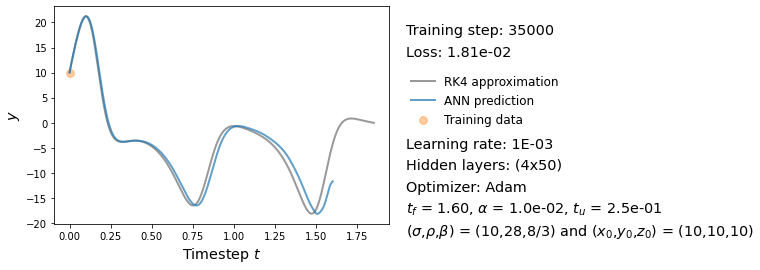

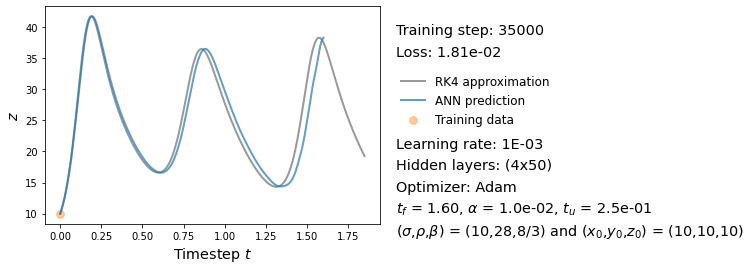

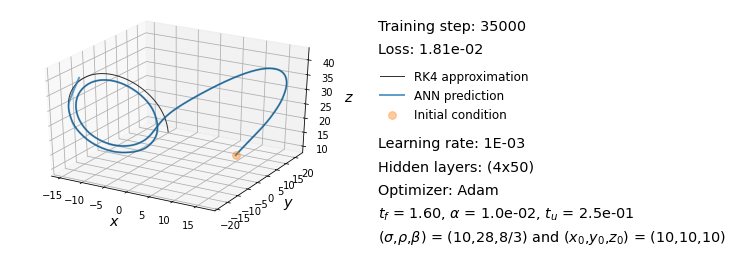

ANN, iteration: 37500, loss: 0.12013199180364609, time: 0:09:26.787034


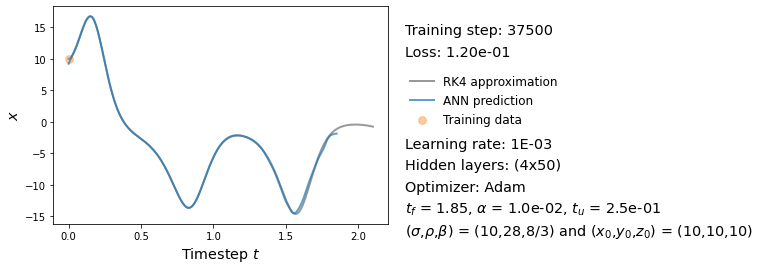

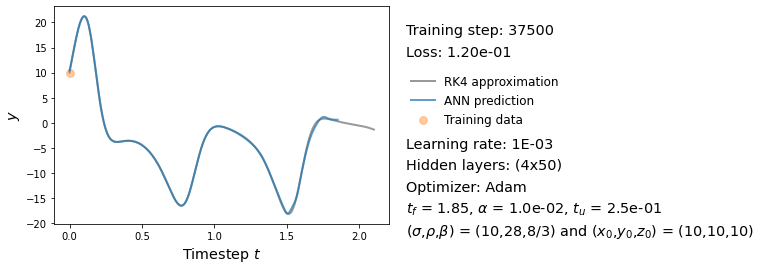

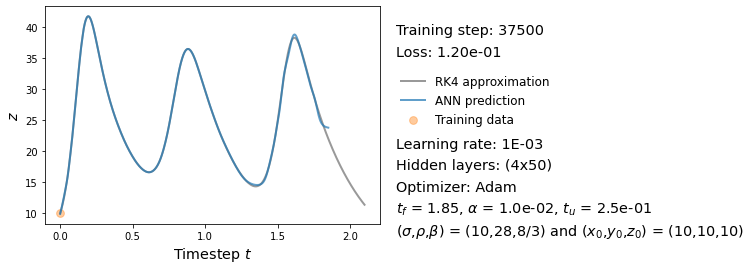

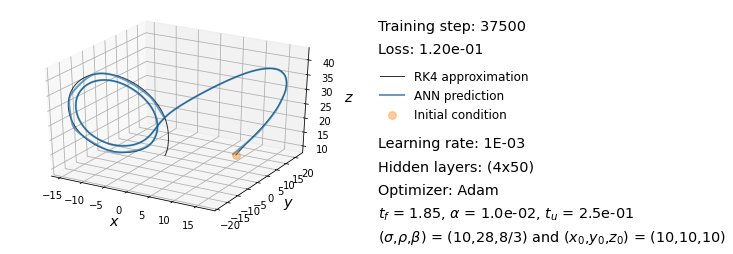

ANN, iteration: 40000, loss: 0.015616736374795437, time: 0:10:05.104626


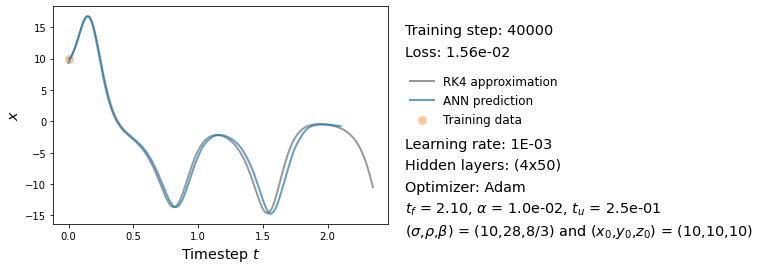

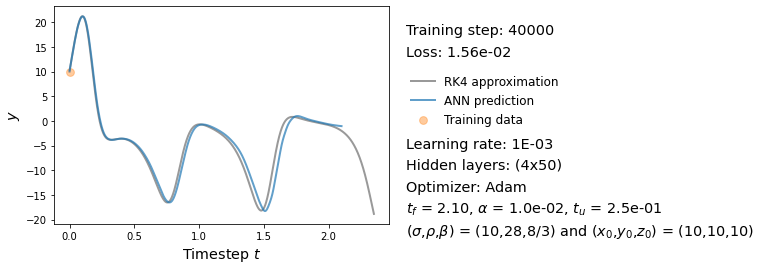

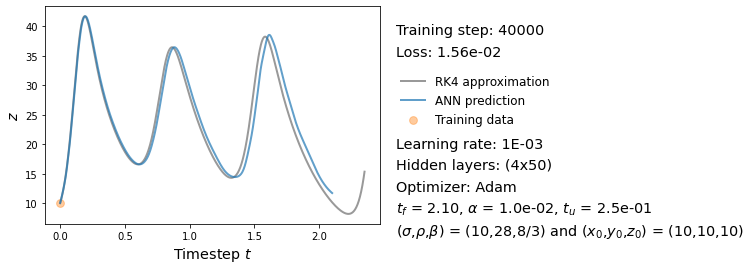

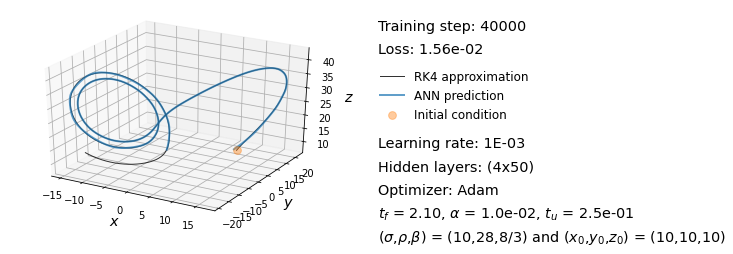

ANN, iteration: 42500, loss: 0.17522357404232025, time: 0:10:43.605157


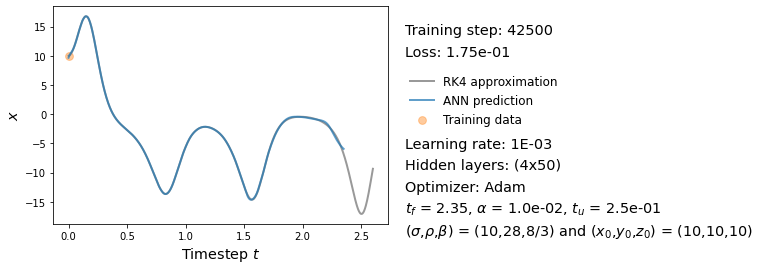

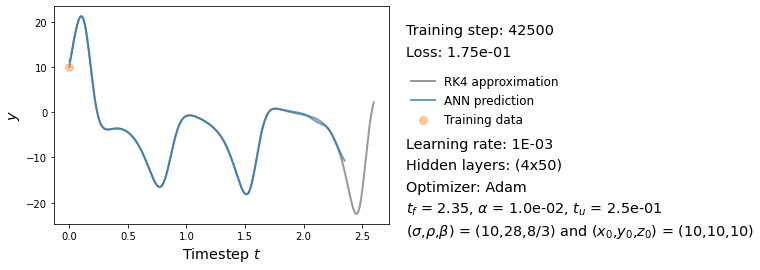

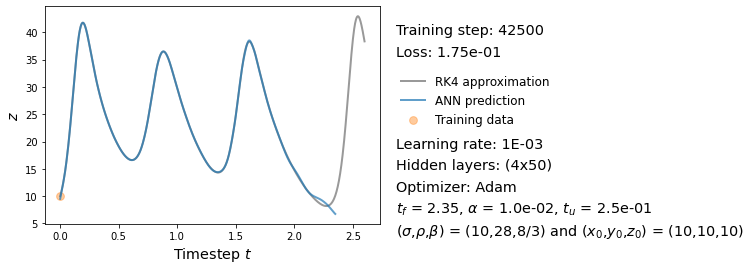

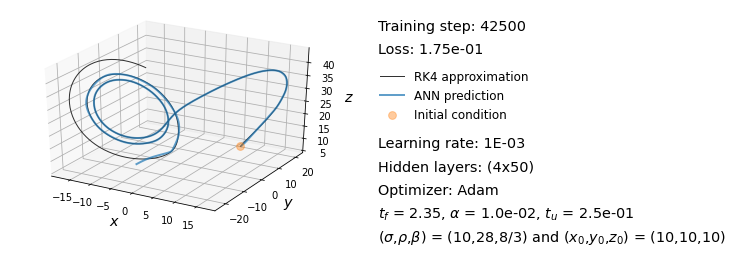

ANN, iteration: 45000, loss: 0.012676360085606575, time: 0:11:22.234367


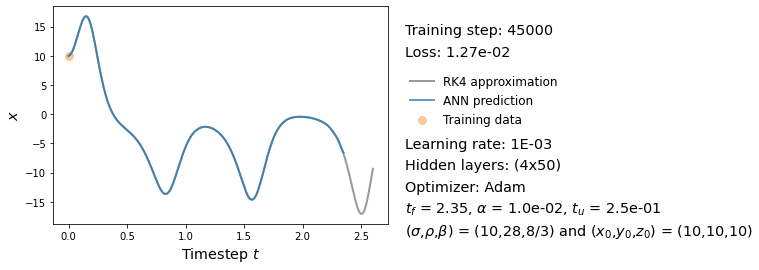

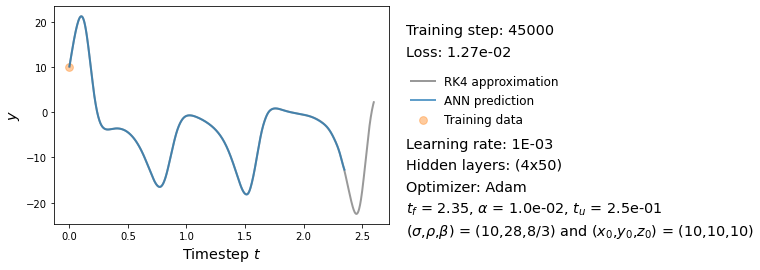

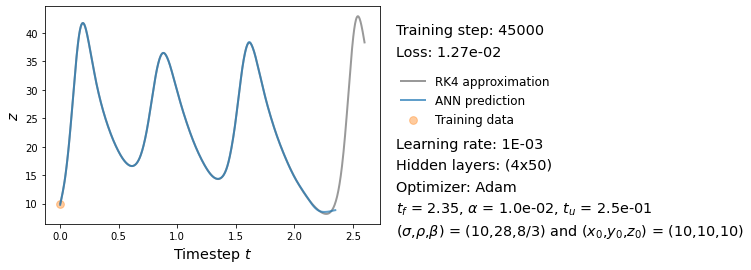

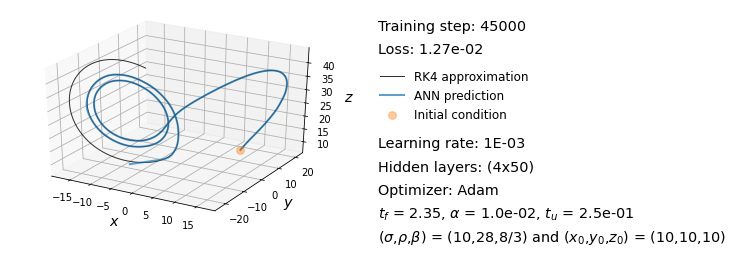

ANN, iteration: 47500, loss: 18.99138069152832, time: 0:12:00.868128


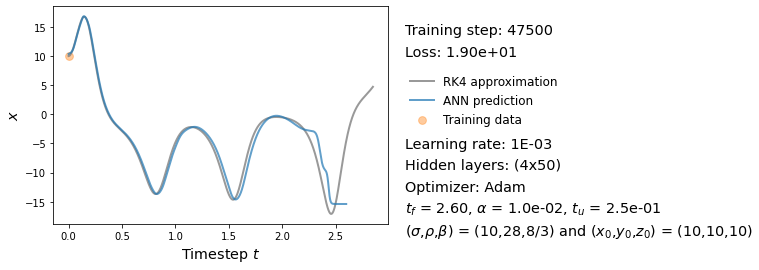

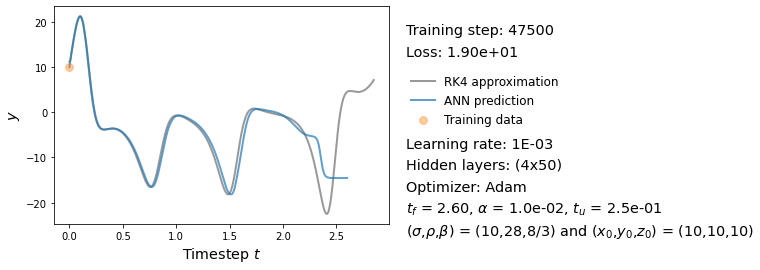

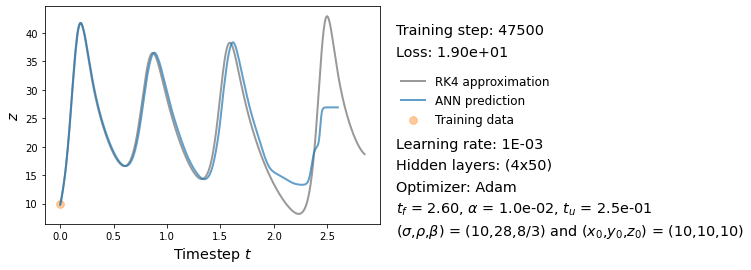

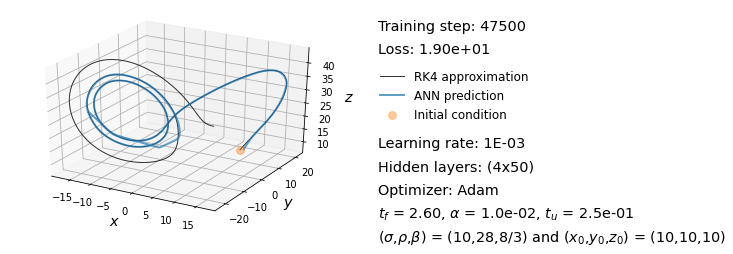

ANN, iteration: 50000, loss: 6.44883918762207, time: 0:12:39.314236


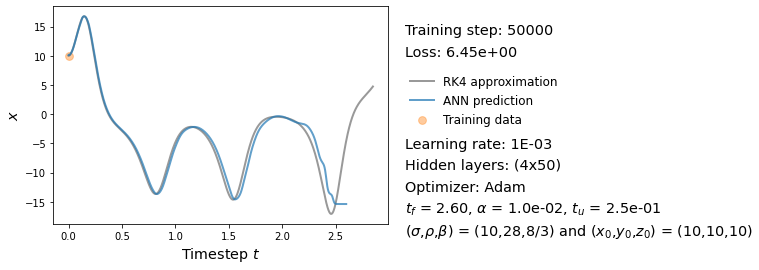

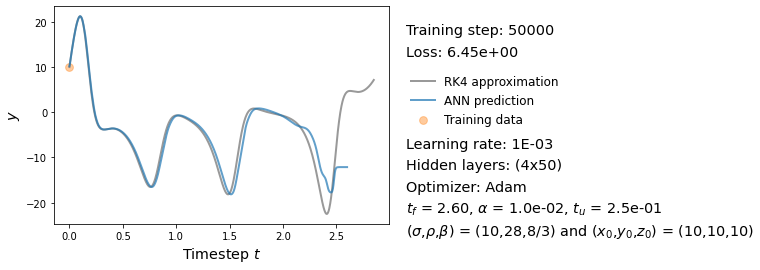

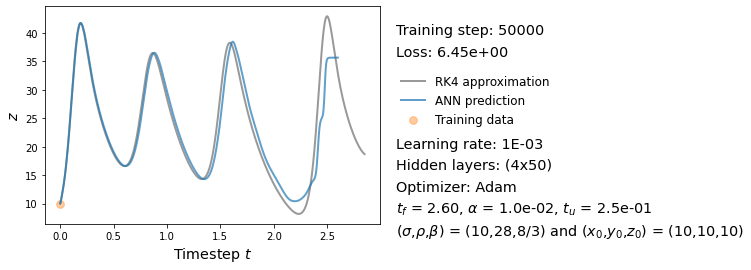

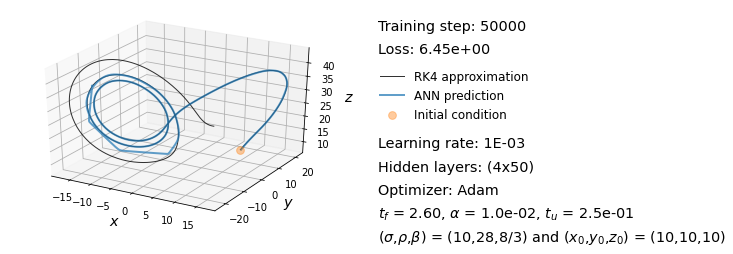

ANN, iteration: 52500, loss: 0.8206231594085693, time: 0:13:18.469281


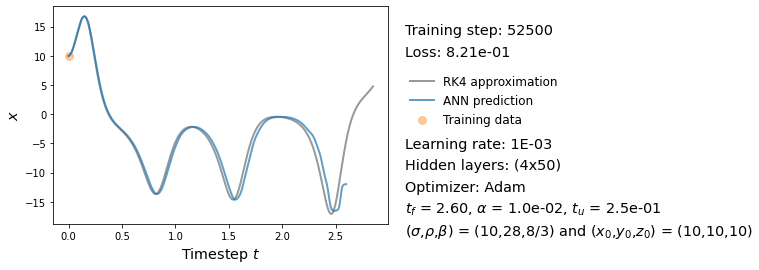

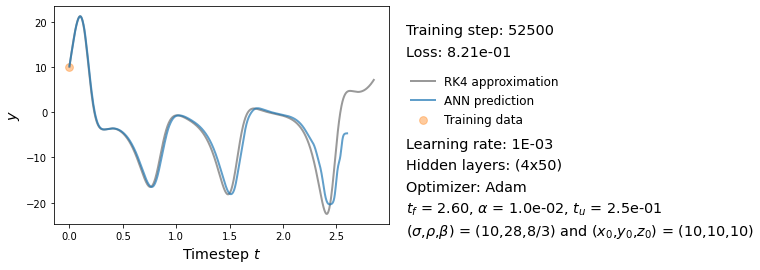

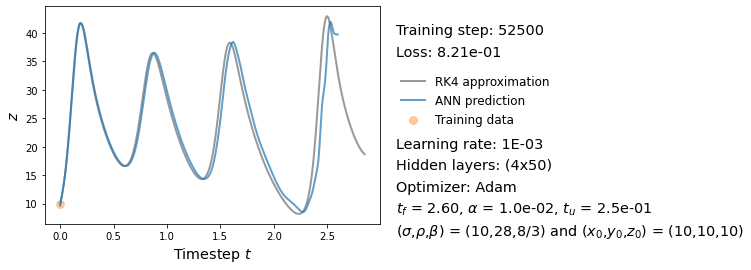

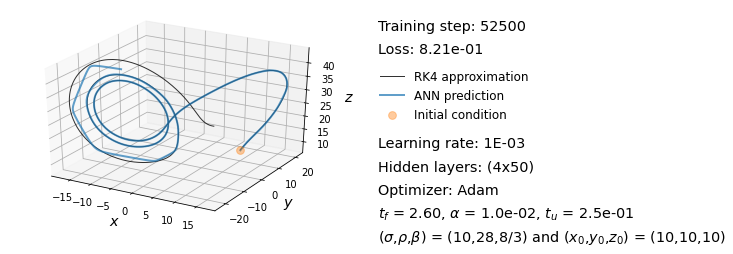

ANN, iteration: 55000, loss: 0.13765743374824524, time: 0:13:57.915661


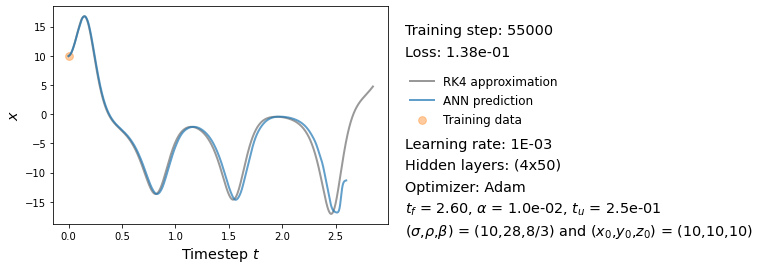

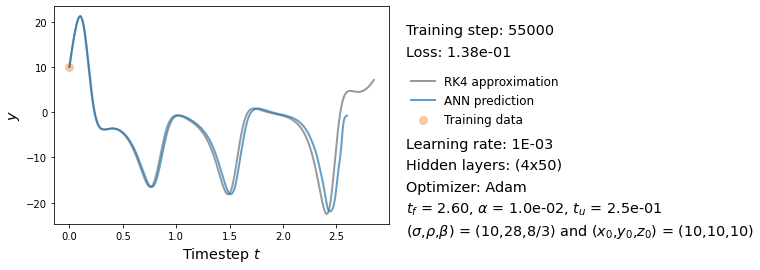

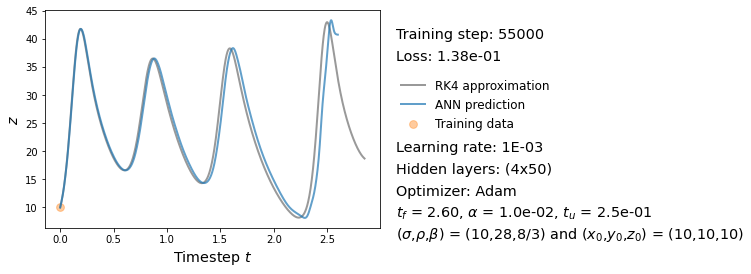

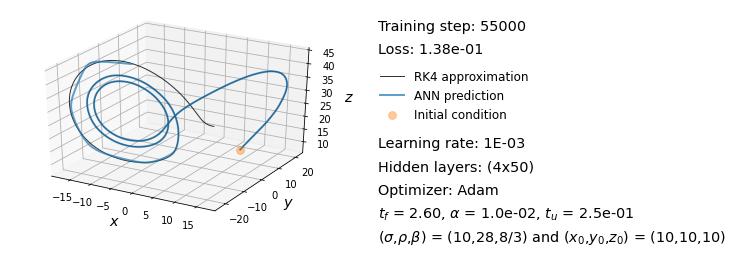

ANN, iteration: 57500, loss: 0.03689577430486679, time: 0:14:36.817274


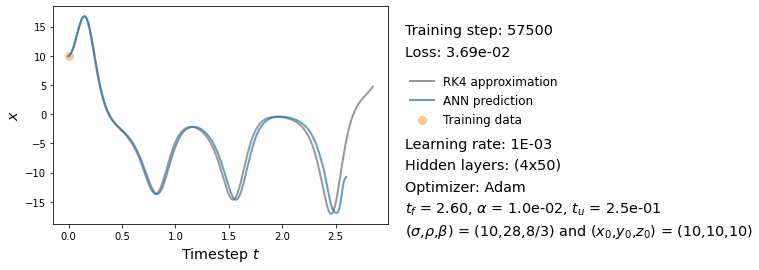

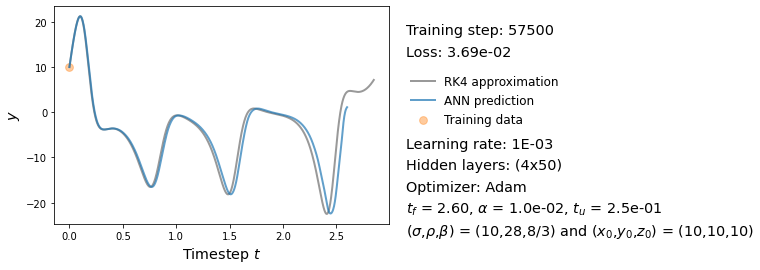

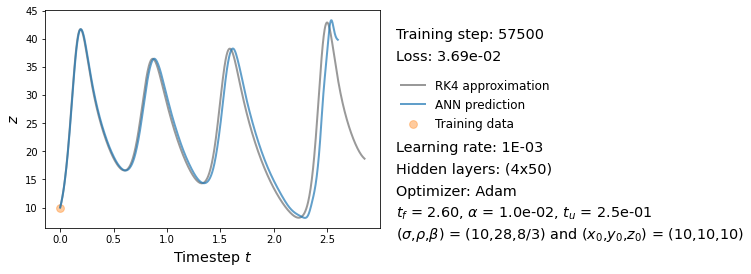

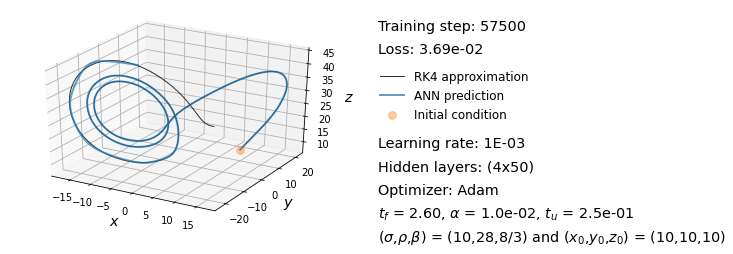

ANN, iteration: 60000, loss: 0.01636457070708275, time: 0:15:14.710838


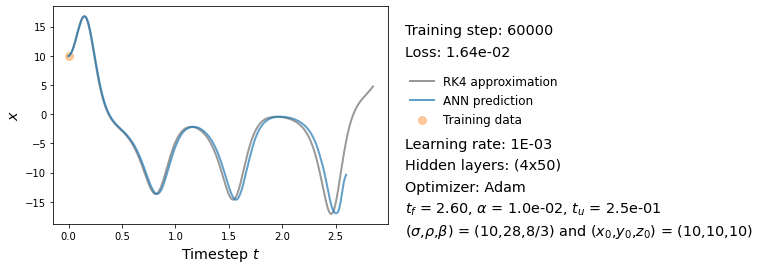

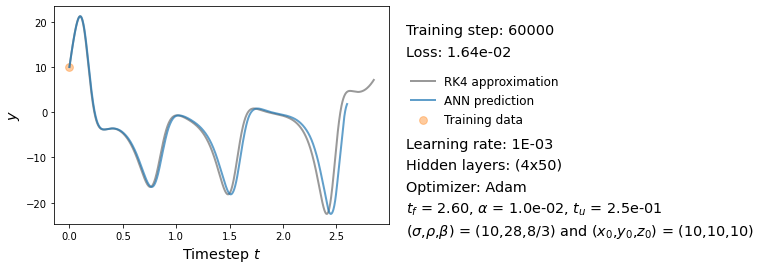

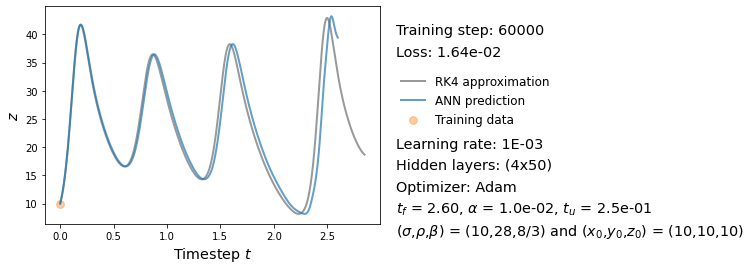

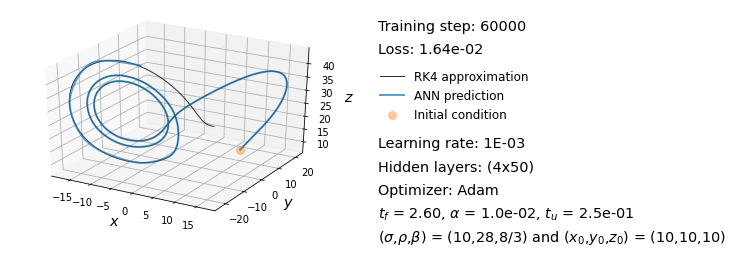

ANN, iteration: 62500, loss: 2.750500202178955, time: 0:15:52.577548


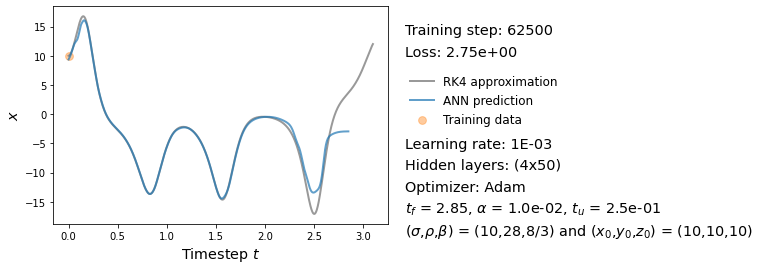

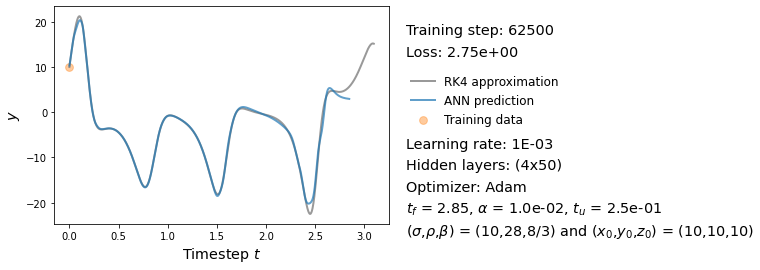

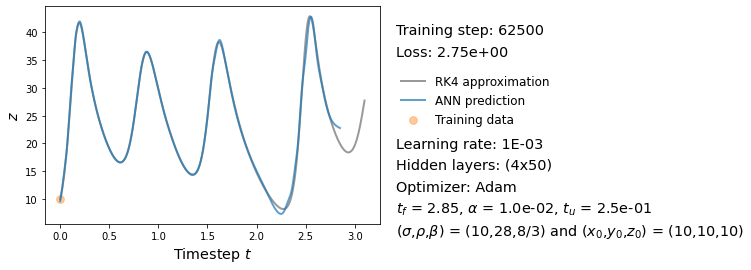

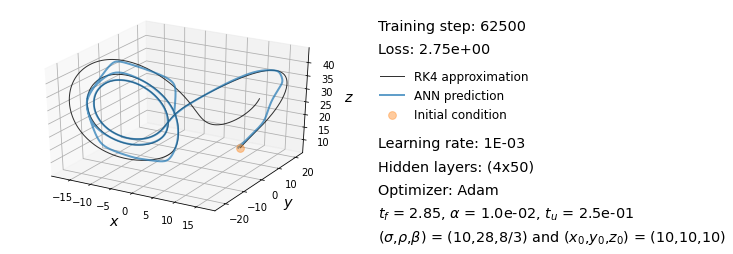

ANN, iteration: 65000, loss: 0.06083188205957413, time: 0:16:30.897632


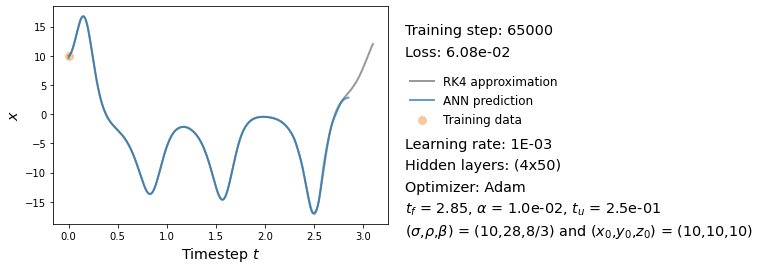

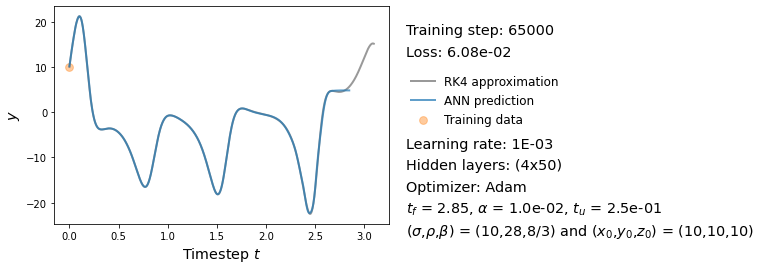

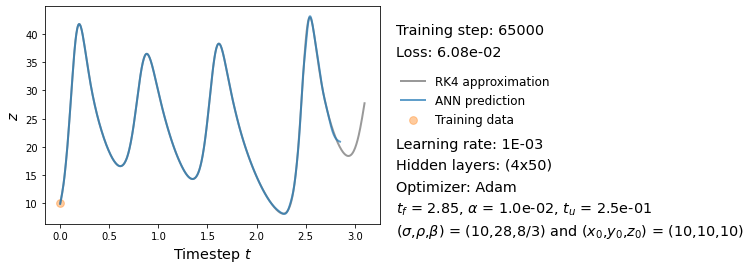

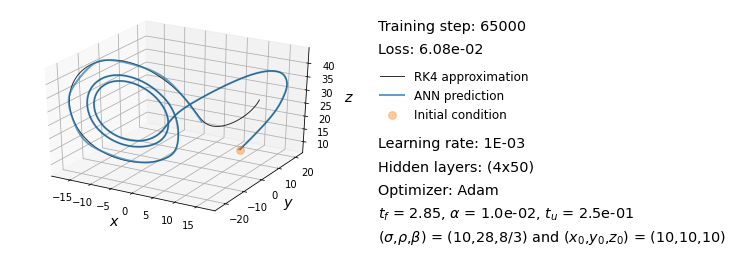

ANN, iteration: 67500, loss: 0.014682336710393429, time: 0:17:09.086155


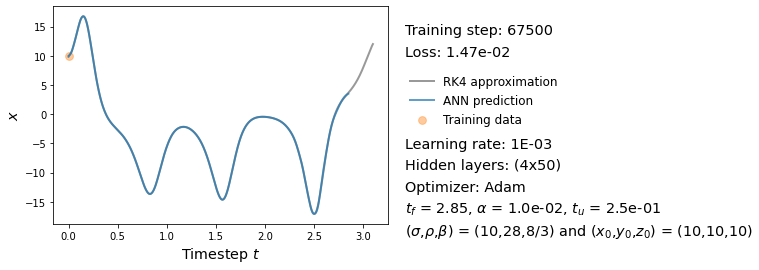

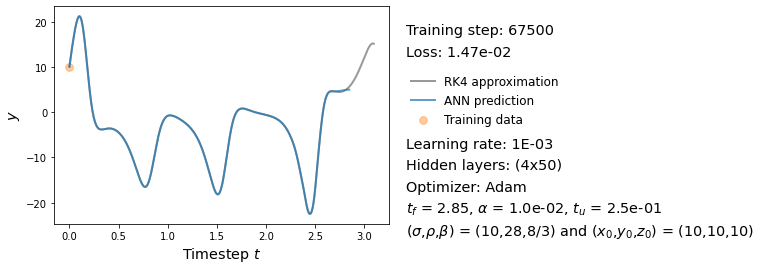

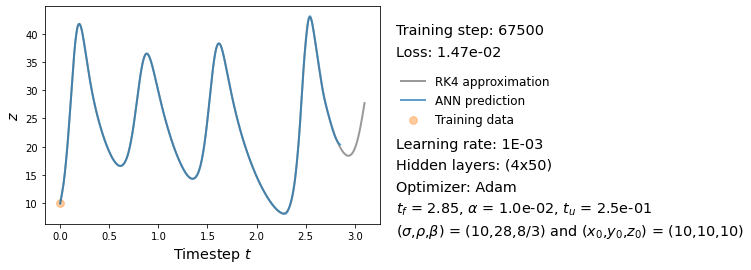

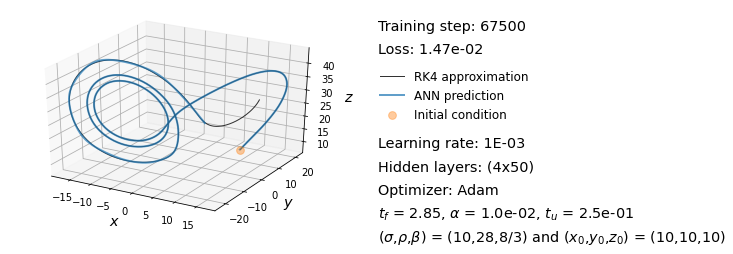

In [ ]:
# Expected runtime: 0:15:08.098624, epochs = 60.000

!mkdir plots
!mkdir plots_x
!mkdir plots_y
!mkdir plots_z

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
time = datetime.now()

warnings.simplefilter(action='ignore', category=FutureWarning)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
torch.manual_seed(12345)
np.random.seed(12345)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

#=============================================================================
#============================  Definitions  ==================================
#=============================================================================
# Fully Connected Network ----------------------------------------------------
class FCN(nn.Module): 
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh #Specify the used activation function
        self.fc1 = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()]) #Input to first hidden layer
        self.fc2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)]) #Going through the remaining hidden layers
        self.fc3 = nn.Linear(N_HIDDEN, N_OUTPUT) #Last hidden layer to output layer

    def forward(self, *args):
        if len(args) == 1: #When multiple initial conditions are specified, this will provide the correct shape. 
            x = args[0]
        elif len(np.shape(args[0])) <= 1:
            x = torch.FloatTensor([*args]).T
        else:
            x = torch.FloatTensor(torch.cat([*args], 1))

        x = self.fc1(x) #Going to the layers
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Runge Kutta fourth order method ---------------------------------------------
def RungeKutta(dxdt,dydt,dzdt, x0,y0,z0, ti,tf,n): # Specify derivatives, initial conditions and time
    h = tf/n #Stepsize
    xl,yl,zl = n*[0],n*[0],n*[0] #Create lists for output
    xl[0],yl[0],zl[0] = x0,y0,z0 #First element in outputlist is initial condition
    for i in range(1,n): #Loop over steps while skipping the first one due to the initial condition
        x,y,z = xl[i-1],yl[i-1],zl[i-1]
        #Going through the four RK4 equations:
        k1x,k1y,k1z = (h*f(x,y,z)    for f in (dxdt,dydt,dzdt))
        xs,ys,zs    = (r + 0.5*kr    for r,kr in zip((x,y,z),(k1x,k1y,k1z,h)))
        k2x,k2y,k2z = (h*f(xs,ys,zs) for f in (dxdt,dydt,dzdt))
        xs,ys,zs    = (r + 0.5*kr    for r,kr in zip((x,y,z),(k2x,k2y,k2z,h)))
        k3x,k3y,k3z = (h*f(xs,ys,zs) for f in (dxdt,dydt,dzdt))
        xs,ys,zs    = (r + kr        for r,kr in zip((x,y,z),(k3x,k3y,k3z,h)))
        k4x,k4y,k4z = (h*f(xs,ys,zs) for f in (dxdt,dydt,dzdt))
        #Update last next value in output list:
        xl[i],yl[i],zl[i] = (r + (k1r + 2*k2r + 2*k3r + k4r)/6 for r,k1r,k2r,k3r,k4r in 
                zip((x,y,z),(k1x,k1y,k1z),(k2x,k2y,k2z),(k3x,k3y,k3z),(k4x,k4y,k4z)))
    return xl,yl,zl

# Plotting of both the RK4 and regression ANN solution in 3D ------------------
def plot_result(x,y,z, x0,y0,z0, xh,yh,zh):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x,y,z, color="black", linewidth=1, alpha=0.8, label="RK4 approximation")
    ax.plot(xh,yh,zh, color="tab:blue", linewidth=2, alpha=0.7, label="ANN prediction")
    ax.scatter(x0, y0, z0, s=60, color="tab:orange", alpha=0.4, label='Initial condition')
    l = plt.legend(loc=(1.1,0.45), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    ax.text2D(0.11, 0.07, "Training step: %i"%(i+1), fontsize="x-large", color="k")
    ax.text2D(0.11, 0.05, "Loss: {:.2e}".format(loss), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.03, "Learning rate: %.0E"%(lr), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.05, "Hidden layers: ({}x{})".format(N_LAYERS, N_HIDDEN), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.07, "Optimizer: Adam", fontsize="x-large", color="k")
    ax.text2D(0.11, -0.09, "$t_f$ = {:.2f}, $\\alpha$ = {:.1e}, $t_u$ = {:.1e}".format(tf, alpha, update_t), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.11, "($\\sigma$,$\\rho$,$\\beta$) = ({},{},8/3) and ($x_0$,$y_0$,$z_0$) = ({},{},{})".format(sigma,rho,x0,y0,z0), fontsize="x-large", color="k")
    ax.set_xlabel('$x$', fontsize="x-large")
    ax.set_ylabel('$y$', fontsize="x-large")
    ax.set_zlabel('$z$', fontsize="x-large")

# Plotting of both the RK4 and regression ANN solution in 2D ------------------
def plot2D(t,exact, t_pred,pred, init,axis):
    plt.figure()
    plt.plot(t,exact, color="grey", linewidth=2, alpha=0.8, label="RK4 approximation")
    plt.plot(t_pred,pred, color="tab:blue", linewidth=2, alpha=0.7, label="ANN prediction")
    plt.scatter(t[0],init, s=60, color="tab:orange", alpha=0.4, label='Training data')
    l = plt.legend(loc=(1.05,0.425), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.annotate("Training step: %i"%(i+1),xy=(1.05, 0.87),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Loss: {:.2e}".format(loss),xy=(1.05, 0.77),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Learning rate: %.0E"%(lr),xy=(1.05, 0.35),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Hidden layers: ({}x{})".format(N_LAYERS, N_HIDDEN),xy=(1.05, 0.25),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Optimizer: Adam",xy=(1.05, 0.15),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("$t_f$ = {:.2f}, $\\alpha$ = {:.1e}, $t_u$ = {:.1e}".format(tf, alpha, update_t),xy=(1.05, 0.05),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("($\\sigma$,$\\rho$,$\\beta$) = ({},{},8/3) and ($x_0$,$y_0$,$z_0$) = ({},{},{})".format(sigma,rho,x0,y0,z0),xy=(1.05, -0.05),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.ylabel('${}$'.format(axis), fontsize="x-large")
    plt.xlabel('Timestep $t$', fontsize="x-large")

# Used to create a iteratively gif-animation of the convergence ---------------
def save_gif(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


#=============================================================================
#============================  Parameters  ===================================
#=============================================================================
# Lorenz system parameters ---------------------------------------------------
x0,y0,z0 = 10,10,10 #Initial conditions
sigma = 10          #Parameters of system:
rho = 28
beta = 8/3
ti = 0              #Initial time
tf = 0.1           #Starting final time (without update)
n = 1000            #Steps taken between ti and tf
h = tf/n            #Stepsize of each step of n

# ANN parameters --------------------------------------------------------------
lr = 1e-3           #Learning rate
N_HIDDEN = 50       #Amount of hidden layers
N_LAYERS = 4        #Amount of neurons in hidden layers
alpha = 0.01        #Threshold value for updating tf with update_t
update_t = 0.25     #Update value for tf after reaching threshold
intermediate = 2500 #Used as stepsize for intermediate plotting

# Lorenz differential equation definitions -----------------------------------
def dxdt_def(x,y,z): return -sigma*x + sigma*y
def dydt_def(x,y,z): return -x*z + rho*x - y
def dzdt_def(x,y,z): return x*y - beta*z


#=============================================================================
#=========================  Identification ANN  ==============================
#=============================================================================
# Define the model -----------------------------------------------------------
model = FCN(1,3,N_HIDDEN,N_LAYERS) #Create a network with the specified hidden layers and neurons
optimizer = torch.optim.Adam(model.parameters(),lr=lr) #Specify the optimizer using the specified the learning rate

loss_hist = []            #To keep track of the loss history
tf_list = []              #List which will update the final time using TEM
files,files_x,files_y,files_z = [],[],[],[] #Create empty files for the intermediate results for the animation
iterations = []           #To keep track of the iterations
i = 0                     #Starting iteration because a while loop is used
while tf < 3.1: #Loop over the iterations (and stop when tf = 3.0 is reached and empirically converged)
    t_physics = torch.linspace(ti,tf,n).view(-1,1).requires_grad_(True) #Time-tensor used in loss training
    x,y,z = torch.FloatTensor(RungeKutta(dxdt_def,dydt_def,dzdt_def, x0,y0,z0, ti,tf,n))

    optimizer.zero_grad() #Set gradients of all optimized tensors to zero

    if len(tf_list) > 0: #For updating the final time in the system
        tf = tf_list[-1]
        h = tf/n
    t_physics = torch.linspace(ti,tf,n).view(-1,1).requires_grad_(True) #Time-tensor used in loss training

    #Calculation of the loss:
    p = model(t_physics)
    px,py,pz = p[:,0],p[:,1],p[:,2]
    physics_x = px - x
    physics_y = py - y
    physics_z = pz - z
    loss = torch.mean(physics_x**2 + physics_y**2 + physics_z**2) #Total loss is the MSE of above residuals

    loss.backward()  #parameter.grad += dloss/d(parameter), for every parameter (the weight/bias matrices)
    optimizer.step() #parameter += -lr * parameter.grad
    
    if loss < alpha: #When dynamic loss2 is below threshold of alpha, add update_t to current tf (TEM)
        tf_list.append(tf + update_t)

    i += 1           #To keep track of the iterations
    iterations.append(i)
    loss = loss.detach()  #This prevents the RAM memory from getting full. 
    loss_hist.append(loss)

    if (iterations[-1]+1)%intermediate == 0: #Plot and save intermediate results
        t_physics = torch.linspace(ti,tf,n).view(-1,1).requires_grad_(True)
        p = model(t_physics)
        print("ANN, iteration: {}, loss: {}, time: {}".format(i+1,loss,datetime.now() - time))
        m1 = torch.squeeze(p.detach())
        xh,yh,zh = m1[:,0],m1[:,1],m1[:,2] #x,y,z results with:
        th = torch.linspace(ti,tf,n).view(-1,1) #corresponding times
        x,y,z = torch.FloatTensor(RungeKutta(dxdt_def,dydt_def,dzdt_def, x0,y0,z0, ti,float('%.2g'%(tf+0.25)),n)) #RK4 results with:
        t = torch.linspace(ti,tf+0.25,n).view(-1,1) #corresponding times that stays +0.25 timesteps above the ANN regressed result. 

        plot2D(t,x, th,xh, x0, "x") #2D (t,x)-plot
        file = "plots_x/regression_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files_x.append(file)
        
        plot2D(t,y, th,yh, y0, "y") #2D (t,y)-plot
        file = "plots_y/regression_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files_y.append(file)
        
        plot2D(t,z, th,zh, z0, "z") #2D (t,z)-plot
        file = "plots_z/regression_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files_z.append(file)
        
        plot_result(x,y,z, x0,y0,z0, xh,yh,zh) #3D plot 
        file = "plots/regression_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        plt.show() #Show plots
      
torch.save(model.state_dict(), 'ANN_model_weights.pth')

#Creating gif-animations:
save_gif("regression_x.gif", files_x, fps=20, loop=0)
save_gif("regression_y.gif", files_y, fps=20, loop=0)
save_gif("regression_z.gif", files_z, fps=20, loop=0)
save_gif("regression.gif", files, fps=20, loop=0)

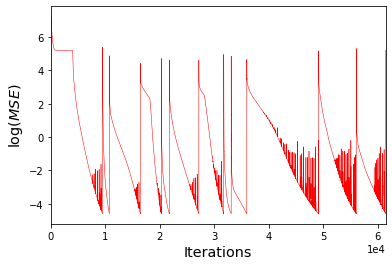

In [ ]:
# Plot of the loss during every iteration in the regression ANN training ------
plt.plot(np.array(np.log(loss_hist)), 'r', linewidth=0.5)
plt.xlabel('Iterations', fontsize='x-large')
plt.ylabel('$\\log(MSE)$', fontsize='x-large')
plt.xlim(0,iterations[-1])
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0)) #Scientific numbers on x-axis
plt.savefig('loss_history_1.png')
plt.show()

# Identification ANN
## The learning of the dynamics of the systems

In [ ]:
# Expected runtime: 0:05:54.198006, epochs needed = 24000
time = datetime.now()
torch.manual_seed(12345)
np.random.seed(12345)

# Takes in a module and applies the Xavier weight initialization --------------
def weights_init_xavier_rule(m):
  classname = m.__class__.__name__
  #for every Linear layer in a model:
  if classname.find('Linear') != -1:
      torch.nn.init.xavier_normal_(m.weight)
      m.bias.data.fill_(0)

class OdeNet(nn.Module):
    def __init__(self, t, ode_layers, activation_fun=nn.Tanh):
        super(OdeNet, self).__init__()

        self.act_fun = activation_fun()

        self.hidden_layers = [nn.Linear(ode_layers[0], ode_layers[1])]
        for idx, width in enumerate(ode_layers[1:-1]):
          if idx < (len(ode_layers[1:-1]) - 1):
            self.hidden_layers.append(nn.Linear(width, ode_layers[idx + 2]))

        self.output_layer = nn.Linear(ode_layers[-2], ode_layers[-1]) 

        self.fnn = self.layers()

    def forward(self, t, model):
        uhat = model.forward(t)
        xhat,yhat,zhat = uhat[:,0],uhat[:,1],uhat[:,2]
        xhat,yhat,zhat = xhat.view(-1,1),yhat.view(-1,1),zhat.view(-1,1)
        terms = torch.cat([xhat,yhat,zhat], 1)
        ode = self.fnn(terms)
        return ode

    def layers(self):
        modules = []
        for idx, layer in enumerate(self.hidden_layers):
            modules.append(layer)
            modules.append(self.act_fun)
        modules.append(self.output_layer)
        return nn.Sequential(*modules)

# (Hyper)parameters of the training -------------------------------------------
ode_layers = [3, 100,100, 3]    #Specify the layers used in the model
lr = 0.001                      #Learning rate
n = 1000                        #Steps taken
tf = 3.0                        #Final time
intermediate = 2000             #For plotting of intermediate results
iterations = []                 #Keeping track of the iterations executed
loss_ode_hist = []              #Keeping track of the loss
e = 0                           #Used as initial iteration
idn_ode_loss = 1                #Used to initiate the while-loop

# Autograd --------------------------------------------------------------------
t = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True)
idn_u_pred = model.forward(t)   #Forward t through the model which outputs x,y,z
xhat,yhat,zhat = idn_u_pred[:,0],idn_u_pred[:,1],idn_u_pred[:,2]
xhat_t = torch.autograd.grad(xhat, t, torch.ones_like(xhat), create_graph=True)[0]
yhat_t = torch.autograd.grad(yhat, t, torch.ones_like(yhat), create_graph=True)[0]
zhat_t = torch.autograd.grad(zhat, t, torch.ones_like(zhat), create_graph=True)[0]

# Define the identification ANN -----------------------------------------------
model_ode = OdeNet(t, ode_layers)
model_ode.apply(weights_init_xavier_rule)
for i in range(len(ode_layers)-2): #Xavier initialization
  model_ode.hidden_layers[i].apply(weights_init_xavier_rule)
ode_optimizer = torch.optim.Adam(model_ode.parameters(), lr=lr) #Optimizer using specified learning rate

while idn_ode_loss > 0.01: #Loop over the iterations (and stop when idn_ode_loss < 0.01). 
    ode_optimizer.zero_grad()
    idn_ode_pred = model_ode.forward(t, model)
    N_pred_x,N_pred_y,N_pred_z = idn_ode_pred[:,0],idn_ode_pred[:,1],idn_ode_pred[:,2]
    N_pred_x,N_pred_y,N_pred_z = N_pred_x.view(-1,1),N_pred_y.view(-1,1),N_pred_z.view(-1,1)
    idn_ode_loss = torch.mean(torch.square(xhat_t - N_pred_x) + torch.square(yhat_t - N_pred_y) + torch.square(zhat_t - N_pred_z))

    idn_ode_loss.backward(retain_graph=True)
    ode_optimizer.step()

    idn_ode_loss = idn_ode_loss.detach() #This prevents the RAM from blowing up due to the retain_graph=True
    loss_ode_hist.append(idn_ode_loss)

    e += 1        #To keep track of the iterations/epochs
    iterations.append(e)

    if e%intermediate == 0: #Plotting of intermediate results
        print("epoch = %6d" % iterations[-1], end="")
        print("  epoch loss = %10.8f" % idn_ode_loss, end="")
        print("  time: {}".format(datetime.now() - time), end="")
        print("\n")

torch.save(model_ode.state_dict(), 'ANN_model_ode_weights.pth')

epoch =   2000  epoch loss = 1785.55517578  time: 0:00:26.682565

epoch =   4000  epoch loss = 261.67578125  time: 0:00:53.578965

epoch =   6000  epoch loss = 26.34894371  time: 0:01:21.126308

epoch =   8000  epoch loss = 3.40607905  time: 0:01:47.387646

epoch =  10000  epoch loss = 0.82578516  time: 0:02:17.155852

epoch =  12000  epoch loss = 0.18394996  time: 0:02:44.556223

epoch =  14000  epoch loss = 0.06855096  time: 0:03:10.855208

epoch =  16000  epoch loss = 0.03114699  time: 0:03:37.714250

epoch =  18000  epoch loss = 0.10907324  time: 0:04:07.134749

epoch =  20000  epoch loss = 0.01528605  time: 0:04:43.391999

epoch =  22000  epoch loss = 0.01244722  time: 0:05:15.005724

epoch =  24000  epoch loss = 0.01022549  time: 0:05:54.198006



## Plot of the loss during the iterations of the ANN identifier

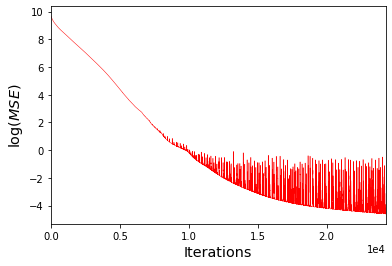

In [ ]:
plt.plot(np.array(np.log(loss_ode_hist)), 'r', linewidth=0.5)
plt.xlabel('Iterations', fontsize='x-large')
plt.ylabel('$\\log(MSE)$', fontsize='x-large')
plt.xlim(0,iterations[-1])
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0)) #Scientific numbers on x-axis
plt.savefig('loss_history_ode2.png')
plt.show()

In [ ]:
# Reloading from already saved models (not necessary) -------------------------
model = FCN(1,3,50,4)
model.load_state_dict(torch.load("ANN_model_weights.pth"))
model.eval()

model_ode = OdeNet(t, ode_layers)
model_ode.load_state_dict(torch.load("ANN_model_ode_weights.pth"))
model_ode.eval()

# PiNN
## The prediction of future states using the previous models

In [ ]:
# Expected runtime: 1:07:21.151819
!mkdir PiNN_plots
torch.manual_seed(12345)
np.random.seed(12345)
time = datetime.now()

class PINN(nn.Module):
  def __init__(self, t, layers, activation_fun=nn.Tanh):
    super(PINN, self).__init__()

    self.act_fun = activation_fun()

    self.hidden_layers = [nn.Linear(u_layers[0], u_layers[1])]
    for idx, width in enumerate(u_layers[1:-1]):
      if idx < (len(u_layers[1:-1]) - 1):
        self.hidden_layers.append(nn.Linear(width, u_layers[idx + 2]))

    self.output_layer = nn.Linear(u_layers[-2], u_layers[-1]) 
    self.fnn = self.layers()
    
  def forward(self, t):
      output = self.fnn(t)
      return output

  def layers(self):
      modules = []
      for idx, layer in enumerate(self.hidden_layers):
          modules.append(layer)
          modules.append(self.act_fun)
      modules.append(self.output_layer)
      return nn.Sequential(*modules)

def plotting(pinn):
    t = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True)
    u_pred = pinn.forward(t)
    x_pred,y_pred,z_pred = u_pred[:,0],u_pred[:,1],u_pred[:,2]
    x_pred,y_pred,z_pred = x_pred.detach().numpy(),y_pred.detach().numpy(),z_pred.detach().numpy()
    x,y,z = torch.FloatTensor(RungeKutta(dxdt_def,dydt_def,dzdt_def, x0,y0,z0, 0,tf,n))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x,y,z, color="black", linewidth=1, alpha=0.8, label="RK4 approximation")
    index = int(regression_index/tf) #till what index is regressed on or from what is predicted
    ax.plot(x_pred[:index],y_pred[:index],z_pred[:index], 'r--', linewidth=2, alpha=0.8, label="PiNN regression")
    ax.plot(x_pred[index:],y_pred[index:],z_pred[index:], 'b', linewidth=2, alpha=0.8, label="PiNN prediction")
    ax.scatter(x0, y0, z0, s=60, color="tab:orange", alpha=0.4, label='Initial condition')
    l = plt.legend(loc=(1.1,0.34), frameon=True, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    ax.text2D(0.11, 0.07, "Training step: %i"%(e), fontsize="x-large", color="k")
    ax.text2D(0.11, 0.05, "Loss: {:.2e}".format(loss), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.05, "$t_f$ = {:.2f}, $\\alpha$ = {:.1e}, $t_u$ = {:.1e}".format(tf, alpha, update_t), fontsize="x-large", color="k")
    ax.set_xlabel('$x$', fontsize="x-large")
    ax.set_ylabel('$y$', fontsize="x-large")
    ax.set_zlabel('$z$', fontsize="x-large")
    file = "PiNN_plots/pinn_%.6i.png"%(e)
    plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
    PiNN_files.append(file)
    plt.show()

# Used to create a iteratively gif-animation of the convergence ---------------
def save_gif(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

# (Hyper)parameters of the training -------------------------------------------
lr = 0.001                       #Learning rate
u_layers = [1, 50,50,50,50, 3]   #Layers of the PiNN
tf_org = 3.0                     #Original training time set
tf = 3.0                         #Test time set
alpha = 0.01
update_t = 0.2
n = 1000                         #Amount of steps
regression_index = tf_org*n      #As help to see until which index the test time set was
intermediate = 1000              #Intermediate plots for the animations

# Some empty lists and starting conditions ------------------------------------
pinn_loss_hist = []
tf_list = []
iterations = []
PiNN_files = []
e = 0 #Starting iteration because a while loop is used
loss = 1 #for starting while loop

tf_help = torch.linspace(0,100,n).view(-1,1).requires_grad_(True) #This list is just for initization of the TEM
t_physics = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True) #Time-list used in dynamic loss2 training

pinn = PINN(t_physics, u_layers)
PiNN_optimizer = torch.optim.Adam(pinn.parameters(),lr=lr) 

N_pred = model_ode.forward(t_physics, model)
N_pred_x,N_pred_y,N_pred_z = N_pred[:,0],N_pred[:,1],N_pred[:,2]
N_pred_x,N_pred_y,N_pred_z = N_pred_x.view(-1,1),N_pred_y.view(-1,1),N_pred_z.view(-1,1)

while tf < 4.1: #Loop over the iterations (and stop when tf = 4.0 is reached and empirically converged)
    PiNN_optimizer.zero_grad()

    if len(tf_list) > 0: #For updating the final time in the system
        tf = tf_list[-1]
        h = tf/n
    t_physics = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True)

    if t_physics[-1] != tf_help[-1]: #to speed up the training instead of having to calculate all gradients again
        pinn = PINN(t_physics, u_layers)
        PiNN_optimizer = torch.optim.Adam(pinn.parameters(),lr=lr) 
        N_pred = model_ode.forward(t_physics, model)
        N_pred_x,N_pred_y,N_pred_z = N_pred[:,0],N_pred[:,1],N_pred[:,2]
        N_pred_x,N_pred_y,N_pred_z = N_pred_x.view(-1,1),N_pred_y.view(-1,1),N_pred_z.view(-1,1)

    #Calculation of loss1 that depends on the initial condition at t=0:
    m = pinn.forward(torch.FloatTensor([0]))
    xh,yh,zh = m[0],m[1],m[2]
    loss1 = torch.mean((xh-x0)**2 + (yh-y0)**2 + (zh-z0)**2)

    #Calculation of loss2 that depends on the dynamics of the system:
    p = pinn.forward(t_physics)
    px,py,pz = p[:,0],p[:,1],p[:,2]
    px,py,pz = px.view(-1,1),py.view(-1,1),pz.view(-1,1) #Correct shape
    dxdt = torch.autograd.grad(px, t_physics, torch.ones_like(px), create_graph=True)[0] #Calculate derivatives of output of PiNN w.r.t. t_physics
    dydt = torch.autograd.grad(py, t_physics, torch.ones_like(py), create_graph=True)[0]
    dzdt = torch.autograd.grad(pz, t_physics, torch.ones_like(pz), create_graph=True)[0]
    physics_x = N_pred_x - dxdt #Calculate f-residuals for the x,y,z differential equations
    physics_y = N_pred_y - dydt
    physics_z = N_pred_z - dzdt
    loss2 = torch.mean(physics_x**2 + physics_y**2 + physics_z**2) #Total loss2 is the MSE of above residuals

    loss = 10*loss1 + loss2 #Total loss with scaling factor of 10 for loss1 due to higher importance of initial condition w.r.t. the dynamic loss
    loss.backward(retain_graph=True)
    loss = loss.detach() #Otherwise the RAM blows up due to the retain_graph=True
    PiNN_optimizer.step()
    
    e += 1        #To keep track of the iterations
    iterations.append(e)
    pinn_loss_hist.append(loss) #Saving all loss values, for the plot in the next cell

    tf_help = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True)

    # Time extension method (TEM)
    if loss < alpha: #When dynamic loss2 is below threshold of alpha, add update_t to current tf
        tf_list.append(tf + update_t)

    if (iterations[-1])%intermediate == 0: #Plotting/printing intermediate results using the iterations list
        print("epoch = %6d" % e, end="")
        print("  epoch loss = %10.8f" % loss, end="")
        print("  time: {}".format(datetime.now() - time), end="")
        print("\n")
        plotting(pinn)

#Creating gif-animations:
save_gif("pinn_prediction.gif", PiNN_files, fps=20, loop=0)
#Saving the model:
torch.save(pinn.state_dict(), 'PiNN_model_weights.pth')

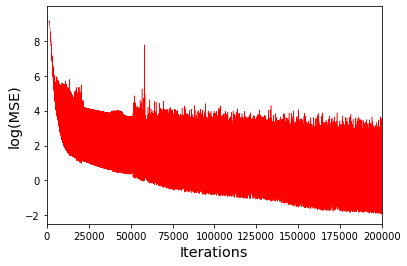

In [ ]:
plt.plot(np.array(np.log(pinn_loss_hist)), 'r', linewidth=0.5)
plt.xlabel('Iterations', fontsize='x-large')
plt.ylabel('$log(MSE)$', fontsize='x-large')
plt.xlim(0,iterations[-1])
plt.savefig('loss_history_pinn.png')
plt.show()

# Plot of final result

In [ ]:
# Plot of the final PiNN prediction
index = int(regression_index/tf) #till what index is regressed on or from what is predicted
u_pred = pinn.forward(t)
x_pred,y_pred,z_pred = u_pred[:,0],u_pred[:,1],u_pred[:,2]
x_pred,y_pred,z_pred = x_pred.detach().numpy(),y_pred.detach().numpy(),z_pred.detach().numpy()
x,y,z = torch.FloatTensor(RungeKutta(dxdt_def,dydt_def,dzdt_def, x0,y0,z0, 0,tf,n))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x,y,z, color="black", linewidth=1, alpha=0.8, label="RK4 approximation")
ax.plot(x_pred[:index],y_pred[:index],z_pred[:index], 'r--', linewidth=2, alpha=0.8, label="PiNN regression")
ax.plot(x_pred[index:],y_pred[index:],z_pred[index:], 'b', linewidth=2, alpha=0.8, label="PiNN prediction")
ax.scatter(x0, y0, z0, s=60, color="tab:orange", alpha=0.4, label='Initial condition')
l = plt.legend(loc=(1.1,0.34), frameon=True, fontsize="large")
plt.setp(l.get_texts(), color="k")
ax.set_xlabel('$x$', fontsize="x-large")
ax.set_ylabel('$y$', fontsize="x-large")
ax.set_zlabel('$z$', fontsize="x-large")

# SAVES
## A different PiNN that is based on just one specified future test time (no TEM)

In [ ]:
# Expected runtime: 1:07:21.151819
!mkdir PiNN_plots
torch.manual_seed(12345)
np.random.seed(12345)
time = datetime.now()

class PINN(nn.Module):
  def __init__(self, t, layers, activation_fun=nn.Tanh):
    super(PINN, self).__init__()

    self.act_fun = activation_fun()

    self.hidden_layers = [nn.Linear(u_layers[0], u_layers[1])]
    for idx, width in enumerate(u_layers[1:-1]):
      if idx < (len(u_layers[1:-1]) - 1):
        self.hidden_layers.append(nn.Linear(width, u_layers[idx + 2]))

    self.output_layer = nn.Linear(u_layers[-2], u_layers[-1]) 
    self.fnn = self.layers()
    
  def forward(self, t):
      output = self.fnn(t)
      return output

  def layers(self):
      modules = []
      for idx, layer in enumerate(self.hidden_layers):
          modules.append(layer)
          modules.append(self.act_fun)
      modules.append(self.output_layer)
      return nn.Sequential(*modules)

PiNN_files = []
def plotting(pinn):
    t = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True)
    u_pred = pinn.forward(t)
    x_pred,y_pred,z_pred = u_pred[:,0],u_pred[:,1],u_pred[:,2]
    x_pred,y_pred,z_pred = x_pred.detach().numpy(),y_pred.detach().numpy(),z_pred.detach().numpy()
    x,y,z = torch.FloatTensor(RungeKutta(dxdt_def,dydt_def,dzdt_def, x0,y0,z0, 0,tf,n))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x,y,z, color="black", linewidth=1, alpha=0.8, label="RK4 approximation")
    index = int(regression_index/tf) #till what index is regressed on or from what is predicted
    ax.plot(x_pred[:index],y_pred[:index],z_pred[:index], 'r--', linewidth=2, alpha=0.8, label="PiNN regression")
    ax.plot(x_pred[index:],y_pred[index:],z_pred[index:], 'b', linewidth=2, alpha=0.8, label="PiNN prediction")
    ax.scatter(x0, y0, z0, s=60, color="tab:orange", alpha=0.4, label='Initial condition')
    l = plt.legend(loc=(1.1,0.34), frameon=True, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    ax.text2D(0.11, 0.07, "Training step: %i"%(e), fontsize="x-large", color="k")
    ax.text2D(0.11, 0.05, "Loss: {:.2e}".format(loss), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.05, "$t_f$ = {:.2f}, $\\alpha$ = {:.1e}, $t_u$ = {:.1e}".format(tf, alpha, update_t), fontsize="x-large", color="k")
    ax.set_xlabel('$x$', fontsize="x-large")
    ax.set_ylabel('$y$', fontsize="x-large")
    ax.set_zlabel('$z$', fontsize="x-large")
    file = "PiNN_plots/pinn_%.6i.png"%(e)
    plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
    PiNN_files.append(file)
    plt.show()

# Used to create a iteratively gif-animation of the convergence ---------------
def save_gif(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

# (Hyper)parameters of the training -------------------------------------------
lr = 0.001                       #Learning rate
u_layers = [1, 50,50,50,50, 3]   #Layers of the PiNN
tf_org = 3.0                     #Original training time set
tf = 3.2                         #Test time set
n = 1000                         #Amount of steps
regression_index = tf_org*n      #As help to see until which index the test time set was
intermediate = 1000              #Intermediate plots for the animations

# Some empty lists and starting conditions ------------------------------------
pinn_loss_hist = []
tf_list = []
iterations = []
e = 0 #Starting iteration because a while loop is used
loss = 1 #for starting while loop

# tf_help = torch.linspace(0,1,n).view(-1,1).requires_grad_(True) #to speed up the training instead of having to calculate all gradients again
t_physics = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True) #Time-list used in dynamic loss2 training

pinn = PINN(t_physics, u_layers)
PiNN_optimizer = torch.optim.Adam(pinn.parameters(),lr=lr) 

N_pred = model_ode.forward(t_physics, model)
N_pred_x,N_pred_y,N_pred_z = N_pred[:,0],N_pred[:,1],N_pred[:,2]
N_pred_x,N_pred_y,N_pred_z = N_pred_x.view(-1,1),N_pred_y.view(-1,1),N_pred_z.view(-1,1)

while loss > 0.01: #Loop over the iterations (and stop when tf = 4.0 is reached and empirically converged)
    PiNN_optimizer.zero_grad()

    #Calculation of loss1 that depends on the initial condition at t=0:
    m = pinn.forward(torch.FloatTensor([0]))
    xh,yh,zh = m[0],m[1],m[2]
    loss1 = torch.mean((xh-x0)**2 + (yh-y0)**2 + (zh-z0)**2)

    #Calculation of loss2 that depends on the dynamics of the system:
    p = pinn.forward(t_physics)
    px,py,pz = p[:,0],p[:,1],p[:,2]
    px,py,pz = px.view(-1,1),py.view(-1,1),pz.view(-1,1) #Correct shape
    dxdt = torch.autograd.grad(px, t_physics, torch.ones_like(px), create_graph=True)[0] #Calculate derivatives of output of PiNN w.r.t. t_physics
    dydt = torch.autograd.grad(py, t_physics, torch.ones_like(py), create_graph=True)[0]
    dzdt = torch.autograd.grad(pz, t_physics, torch.ones_like(pz), create_graph=True)[0]
    physics_x = N_pred_x - dxdt #Calculate f-residuals for the x,y,z differential equations
    physics_y = N_pred_y - dydt
    physics_z = N_pred_z - dzdt
    loss2 = torch.mean(physics_x**2 + physics_y**2 + physics_z**2) #Total loss2 is the MSE of above residuals

    loss = 10*loss1 + loss2 #Total loss with scaling factor of 10 for loss1 due to higher importance of initial condition w.r.t. the dynamic loss
    loss.backward(retain_graph=True)
    loss = loss.detach() #Otherwise the RAM blows up due to the retain_graph=True
    PiNN_optimizer.step()
    pinn_loss_hist.append(loss) #Saving all loss values, for the plot in the next cell

    e += 1        #To keep track of the iterations
    iterations.append(e)

    if (iterations[-1])%intermediate == 0: #Plotting/printing intermediate results using the iterations list
        print("epoch = %6d" % e, end="")
        print("  epoch loss = %10.8f" % loss, end="")
        print("  time: {}".format(datetime.now() - time), end="")
        print("\n")
        plotting(pinn)

#Creating gif-animations:
save_gif("pinn_prediction.gif", PiNN_files, fps=20, loop=0)
#Saving the model:
torch.save(pinn.state_dict(), 'PiNN_model_weights.pth')